Run the following command in terminal before starting the jupyter notebook server.
```bash
source /usr/local/gromacs/bin/GMXRC
```

In [2]:
import pandas as pd
import numpy as np
import nglview as ng
import mdtraj as md
import matplotlib.pyplot as plt
import seaborn as sns
import gromacs

/home/elizaveta/miniconda3/envs/meeteu/lib/python3.8/site-packages/gromacs/__init__.py:286: GromacsImportWarning: Some Gromacs commands were NOT found; maybe source GMXRC first? The following are missing:
['release']

  warnings.warn("Some Gromacs commands were NOT found; "


In [3]:
# Run once
#gromacs.config.setup()

Useful: https://link.springer.com/chapter/10.1007/978-981-15-6815-2_7

# Molecular Docking Simulation Protokoll

In [1]:
structure = "7NIO"

Force field used: CHARMM36 (July 2022), accessible through http://mackerell.umaryland.edu/charmm_ff.shtml#gromacs

For ligand preparation CGenFF 4.6 was used: https://cgenff.umaryland.edu/

Water model: TIP3P CHARMM-modified

.mdp files adapted from http://www.mdtutorials.com/gmx/complex/

## Selection of the top ranked hits from docking

Firstly, we select 5 molecules with the top docking scores.

In [15]:
results_file = (f"../docking/{structure}_pocket1/refinement_docking_23-01-28_12-46/"
                f"{structure}_pocket1_docking_results_merged_filtered_-11_23-01-28_12-46.csv")
results_df = pd.read_csv(results_file)
results_df = results_df.sort_values('Score')
results_df.head(5)

,Molecule,Score
322,O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1,-16.786
324,Cc1n[nH]c(CN2CC3CCC[C@@H](C2)NC3=O)n1,-15.867
297,O=C1N[C@H]2CCCC1CN(C(=O)NCCSCc1cccc(Cl)c1)C2,-15.026
527,CN1CCCN(C(=O)N[C@H]2CCCOc3ccc(F)cc32)CC1,-14.954
377,CC(C)CCOc1ccccc1CCNC(=O)N1CC2CCC[C@@H](C1)NC2=O,-14.926


Print the names of the top 5 molecules as a list in bash.

In [19]:
for i in range(5):
    print("'"+results_df.iloc[i, 0]+"'")

'O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1'
'Cc1n[nH]c(CN2CC3CCC[C@@H](C2)NC3=O)n1'
'O=C1N[C@H]2CCCC1CN(C(=O)NCCSCc1cccc(Cl)c1)C2'
'CN1CCCN(C(=O)N[C@H]2CCCOc3ccc(F)cc32)CC1'
'CC(C)CCOc1ccccc1CCNC(=O)N1CC2CCC[C@@H](C1)NC2=O'


By using produced list copy the .pdbqt files of the poses produced by docking to the md_simulation/Sample folder.

In [72]:
%%bash -s "$structure"
smiles=('O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1'
        'Cc1n[nH]c(CN2CC3CCC[C@@H](C2)NC3=O)n1'
        'O=C1N[C@H]2CCCC1CN(C(=O)NCCSCc1cccc(Cl)c1)C2'
        'CN1CCCN(C(=O)N[C@H]2CCCOc3ccc(F)cc32)CC1'
        'CC(C)CCOc1ccccc1CCNC(=O)N1CC2CCC[C@@H](C1)NC2=O')

for i in {1..5}
do
    mol=${smiles[$i-1]}
    #mkdir 7NIO_pocket1/lig${i}
    
    # Copy .pdbqt files
    cp ../docking/${1}_pocket1/refinement_docking_23-01-28_12-46/${mol}_pose.pbqt \
        ${1}_pocket1/lig${i}/lig${i}_pose.pbqt
    
    # Replace G atoms (CG0 etc.) with C atoms (AutoDock Vina artifact), than replace CC0/CC1/C0/C1 with C
    sed "s/G/C/g" ${1}_pocket1/lig${i}/lig${i}_pose.pbqt | sed "s/C0/C/g" | sed "s/C1/C/g"\
        | sed "s/CC/C/g" > ${1}_pocket1/lig${i}/lig${i}_fixed.pdbqt
    
    # Tranform to .mol2 (CGenFF input format)
    obabel -ipdbqt ${1}_pocket1/lig${i}/lig${i}_fixed.pdbqt -omol2 -O ${1}_pocket1/lig${i}/lig${i}.mol2
    
done

1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted


As shown below OpenBabel fails to identify all bonds correctly. Therefore manual correction with Avogadro Software is neede. Avogadro is additionally used to add missing hydrogen atoms.<br>
1. Build -> Add Hydrogens
2. Activate drawing mode. <br>
    2.1. Left click-> delete atom. <br>
    2.2. Click on atom and drag to the other atom -> add a bond. <br>
    2.3. Click on the bond -> single to double, double to triple, triple to single

**OUTPUT**: ligX_fixed.mol2

In [85]:
view = ng.show_structure_file(f"/home/elizaveta/meeteu/md_simulations/{structure}_pocket1/lig1/lig1_fixed.pdb")
view

NGLWidget()

Replace *** with molecule name at the start of the .mol2 files. Also all atoms should be attributed to LIGX (not to UNL11/UNL1). <br>
Finally, the bonds should be sorted. For this we are using the sort_mol2_bonds.pl perl script (by Justin A. Lemkul, Ph.D., http://www.mdtutorials.com/gmx/complex/Files/sort_mol2_bonds.pl).

In [94]:
%%bash -s "$structure"
for i in {1..5}
do
    # Replace '*****' with 'LIGX'
    sed -i "s/\*\*\*\*\*/LIG${i}/g" ${1}_pocket1/lig${i}/lig${i}_fixed.mol2
    
    # Replace UNL1/UNL11 with LIGX
    sed "s/UNL11/LIG${i}/g" ${1}_pocket1/lig${i}/lig${i}_fixed.mol2 | sed "s/UNL1/LIG${i}/g" > ${1}_pocket1/lig${i}/lig${i}_fixed2.mol2
    
    # Sort the bonds
    perl sort_mol2_bonds.pl ${1}_pocket1/lig${i}/lig${i}_fixed.mol2 ${1}_pocket1/lig${i}/lig${i}_final.mol2
done

Found 61 atoms in the molecule, with 63 bonds.


## Prepare the protein

The .pdb file can be founf in the Nsp13Structures folder. Open in PyMOL, delete Zinc ions and save the structure without the ions. <br>
**OUTPUT** 7nio_A_noZN.pdb

There are still following issues with this structure:
1. C-Terminus is missing an Oxygen (add in PyMOL editing mode). Also changed the indexes of the residues to start with 1, instead of with 0 (in PyMOL)<br>
   **OUTPUT** 7nio_A_noZN_terCOOH.pdb                                                                  
2. The file is PDB_v3, GROMACS accepts PDB_v2 => use -ignh in pdb2gmx, in this case also convert

Conversion:<br>
Generally would not be needed (-ignh in pdb2gmx), but had to change the name of the oxygen that was manually added (O01 to OXT). Otherwise got an error. How the atom names should be changed can be understood by comparing the .pdb file to the aminoacids.c.tdb in this case. In other cases it could be arminoacids.n.tdb (issue with N-terminus) or aminoacids.rtp (issue with not terminal atoms).

## Writing topology

### Ligand
Load molecules to CGenFF. The options "Include parameters that are already in CGenFF" and "Guess bond orders from connectivity" were NOT selected.<br>
**OUTPUT**: ligX_final.str  

Next step is transforming the files to GROMACS input. For this we use script from the developers of the CHARMM36 force field (MacKerell lab, http://mackerell.umaryland.edu/charmm_ff.shtml#gromacs)

In [95]:
%%bash -s "$structure"
for i in {1..5}
do
    python cgenff_charmm2gmx_py3_nx2.py LIG${i} ${1}_pocket1/lig${i}/lig${i}_final.mol2 \
        ${1}_pocket1/lig${i}/lig${i}_final.str charmm36-jul2022.ff
done

NOTE 1: Code tested with Python 3.5.2 and 3.7.3. Your version: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:49:35) 
[GCC 10.4.0]

NOTE 2: Code tested with NetworkX 2.3. Your version: 2.3

NOTE 3: Please be sure to use the same version of CGenFF in your simulations that was used during parameter generation:
--Version of CGenFF detected in  7NIO_pocket1/lig1/lig1_final.str : 4.6
--Version of CGenFF detected in  charmm36-jul2022.ff/forcefield.doc : 4.6

NOTE 4: To avoid duplicated parameters, do NOT select the 'Include parameters that are already in CGenFF' option when uploading a molecule into CGenFF.
============ DONE ============
Conversion complete.
The molecule topology has been written to lig1.itp
Additional parameters needed by the molecule are written to lig1.prm, which needs to be included in the system .top

PLEASE NOTE: If your topology has lone pairs, you must use GROMACS version 2020 or newer to use 2fd construction
Older GROMACS versions WILL NOT WORK as they

**OUTPUT**: ligX.itp, ligX.prm, ligX.top, ligX_ini.pdb<br>
Move the resulting files to the correct directories.

In [98]:
%%bash -s "$structure"
for i in {1..5}
do
    mv lig${i}* ${1}_pocket1/lig${i}
done

Convert ligX_ini.pdb to .gro format.<br>
**OUTPUT** ligX.gro

In [3]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx editconf -f ${1}_pocket1/lig${i}/lig${i}_ini.pdb \
        -o ${1}_pocket1/lig${i}/lig${i}.gro
done

                     :-) GROMACS - gmx editconf, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx editconf -f 7NIO_pocket1/lig1/lig1_ini.pdb -o 7NIO_pocket1/lig1/lig1.gro


GROMACS reminds you: "I Am a Wonderful Thing" (Kid Creole)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 39 atoms
No velocities found

See the GROMACS manual for a description of the requirements that
must be satisfied by descriptions of simulation cells.


                     :-) GROMACS - gmx editconf, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx editconf -f 7NIO_pocket1/lig2/lig2_ini.pdb -o 7NIO_pocket1/lig2/lig2.gro


GROMACS reminds you: "I Am a Wonderful Thing" (Kid Creole)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 37 atoms
No velocities found

See the GROMACS manual for a description of the requirements that
must be satisfied by descriptions of simulation cells.


                     :-) GROMACS - gmx editconf, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx editconf -f 7NIO_pocket1/lig3/lig3_ini.pdb -o 7NIO_pocket1/lig3/lig3.gro


GROMACS reminds you: "I Am a Wonderful Thing" (Kid Creole)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 50 atoms
No velocities found

See the GROMACS manual for a description of the requirements that
must be satisfied by descriptions of simulation cells.


                     :-) GROMACS - gmx editconf, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx editconf -f 7NIO_pocket1/lig4/lig4_ini.pdb -o 7NIO_pocket1/lig4/lig4.gro


GROMACS reminds you: "I Am a Wonderful Thing" (Kid Creole)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 47 atoms
No velocities found

See the GROMACS manual for a description of the requirements that
must be satisfied by descriptions of simulation cells.


                     :-) GROMACS - gmx editconf, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx editconf -f 7NIO_pocket1/lig5/lig5_ini.pdb -o 7NIO_pocket1/lig5/lig5.gro


GROMACS reminds you: "I Am a Wonderful Thing" (Kid Creole)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 61 atoms
No velocities found

See the GROMACS manual for a description of the requirements that
must be satisfied by descriptions of simulation cells.


### Protein

Write topology. Run in terminal because prompted to chose the force field (select CHARMM36). The CHARMM36 force field should be saved in the folder 7NIO_pocket1. Manually select terminal configuration (default is NH3+ and COO-, which was not the case here)<br>
```bash
gmx pdb2gmx -f 7NIO_pocket1/7nio_A_noZN_terCOOH.pdb -o 7NIO_pocket1/7nio_A.gro -ter -ignh
> Select force field: 1 (CHARMM36)
> Select water model: 1 (TIP3P, CHARMM-modified)
> N-terminus: 2 (NH2)
> C-terminus: 1 (COOH)
```
**OUTPUT**: 7nio_A.gro

In [106]:
view = ng.show_structure_file(f"{structure}_pocket1/{structure}_A.gro")
view

NGLWidget()

### Complex

To create a .gro file, following steps should be taken:
1. Copy header from protein.gro
2. In the second line write the total atom number (protein + ligand)
3. Copy protein atom data
4. Copy ligand atom data
5. Copy footer from protein.gro
**OUTPUT** complex_ligX.gro

In [16]:
prot_path = f"{structure}_pocket1/7nio_A.gro"
for i in range(1,6):
    
    lig_path = f"{structure}_pocket1/lig{i}/lig{i}.gro"
    out_path = f"{structure}_pocket1/lig{i}/complex_lig{i}.gro"
    prot_lines = []
    lig_lines = []
    
    # Read protein data
    with open(prot_path, 'r') as prot_file:
        header = prot_file.readline()
        # Number of atoms
        prot_n = int(prot_file.readline())
        
        line = prot_file.readline()
        while len(line.split())==6:
            prot_lines.append(line)
            line = prot_file.readline()
            
        footer = line
    
    # Read ligand data
    with open(lig_path, 'r') as lig_file:
        _ = lig_file.readline()
        # Numeber of atoms
        lig_n = int(lig_file.readline())
        
        line = lig_file.readline()
        while len(line.split())==6:
            lig_lines.append(line)
            line = lig_file.readline()
    
    # Write complex
    with open(out_path, 'w') as out_file:
        out_file.write(header)
        out_file.write(str(prot_n+lig_n)+'\n')
        out_file.writelines(prot_lines)
        out_file.writelines(lig_lines)
        out_file.write(footer)

Build complex topology. A separate .top file is needed for each complex. Steps:
1. Add ligand .itp file after Position restraint file of the protein
2. Add ligand .prm file after force field parameters
3. Add ligand to the \[molecules\] field
4. The paths for file in #include should be changed, because topol.top is in another directory than complex_ligX.top
**OUTPUT** complex_ligX.top

In [53]:
# Correct if the line contains path (go two directories up)
def correct_path(line):
    if line.startswith('#include'):
        line_l = line.partition('"')
        new_line = line_l[0]+line_l[1]
        if line_l[2].startswith('.'):
            path = line_l[2][2:] # delete the ./ at the beginning
        else:
            path = line_l[2]
        new_line = new_line + "../../" + path
    else:
        new_line=line
    return new_line

original_path = "topol.top"
for i in range(1, 6):
    output_path = f"{structure}_pocket1/lig{i}/complex_lig{i}.top"

    with open(original_path, 'r') as i_file:
        with open(output_path, 'w') as o_file:
            line = i_file.readline()

            # Copy lines until encounter forcefield parameters lines
            while line.startswith('; Include forcefield parameters')==False:
                o_file.write(correct_path(line))
                line=i_file.readline()
            o_file.write(correct_path(line)) # ; Include forcefield parameters
            line=i_file.readline()
            o_file.write(correct_path(line)) # #include "./charmm36..."
            line=i_file.readline()
            o_file.write('\n')

            # Include ligand parameters
            o_file.write('; Include ligand parameters\n')
            o_file.write(f"#include \"lig{i}.prm\"\n")

            # Copy line until encounter position restraint
            while line.startswith('; Include Position restraint file')==False:
                o_file.write(correct_path(line))
                line=i_file.readline()
            # Copy the next 4 lines
            for a in range(4):
                o_file.write(correct_path(line))
                line=i_file.readline()
            o_file.write('\n')

            #Include ligand topology
            o_file.write('; Include ligand topology\n')
            o_file.write(f"#include \"lig{i}.itp\"\n")

            # Copy until encounter [molecules]
            while line.startswith('[ molecules ]')==False:
                o_file.write(correct_path(line))
                line=i_file.readline()
            # Copy the next two lines
            for a in range(3):
                o_file.write(correct_path(line))
                line=i_file.readline()

            # Add the ligand molecule
            o_file.write(f"LIG{i}                1")
            o_file.write('\n')

## System preparation
### Box definition

In [54]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx editconf -f ${1}_pocket1/lig${i}/complex_lig${i}.gro\
        -o ${1}_pocket1/lig${i}/box_lig${i}.gro -bt dodecahedron -d 1.0
done

                     :-) GROMACS - gmx editconf, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx editconf -f 7NIO_pocket1/lig1/complex_lig1.gro -o 7NIO_pocket1/lig1/box_lig1.gro -bt dodecahedron -d 1.0


GROMACS reminds you: "You should never bet against anything in science at odds of more than about 10^12 to 1." (Ernest Rutherford)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 9294 atoms
Volume: 410.634 nm^3, corresponds to roughly 184700 electrons
No velocities found
    system size :  6.892  8.564  6.956 (nm)
    diameter    :  9.735               (nm)
    center      : -1.844  1.993 -2.706 (nm)
    box vectors :  6.892  8.564  6.957 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 410.63               (nm^3)
    shift       : 10.645  6.807  6.855 (nm)
new center      :  8.801  8.801  4.149 (nm)
new box vectors : 11.735 11.735 11.735 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  :1142.60               (nm^3)


                     :-) GROMACS - gmx editconf, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx editconf -f 7NIO_pocket1/lig2/complex_lig2.gro -o 7NIO_pocket1/lig2/box_lig2.gro -bt dodecahedron -d 1.0


GROMACS reminds you: "You should never bet against anything in science at odds of more than about 10^12 to 1." (Ernest Rutherford)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 9292 atoms
Volume: 410.634 nm^3, corresponds to roughly 184700 electrons
No velocities found
    system size :  6.892  8.564  6.956 (nm)
    diameter    :  9.735               (nm)
    center      : -1.843  1.994 -2.706 (nm)
    box vectors :  6.892  8.564  6.957 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 410.63               (nm^3)
    shift       : 10.644  6.807  6.855 (nm)
new center      :  8.801  8.801  4.149 (nm)
new box vectors : 11.735 11.735 11.735 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  :1142.60               (nm^3)


                     :-) GROMACS - gmx editconf, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx editconf -f 7NIO_pocket1/lig3/complex_lig3.gro -o 7NIO_pocket1/lig3/box_lig3.gro -bt dodecahedron -d 1.0


GROMACS reminds you: "You should never bet against anything in science at odds of more than about 10^12 to 1." (Ernest Rutherford)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 9305 atoms
Volume: 410.634 nm^3, corresponds to roughly 184700 electrons
No velocities found
    system size :  6.892  8.564  6.956 (nm)
    diameter    :  9.735               (nm)
    center      : -1.845  1.992 -2.706 (nm)
    box vectors :  6.892  8.564  6.957 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 410.63               (nm^3)
    shift       : 10.646  6.809  6.855 (nm)
new center      :  8.801  8.801  4.149 (nm)
new box vectors : 11.735 11.735 11.735 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  :1142.60               (nm^3)


                     :-) GROMACS - gmx editconf, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx editconf -f 7NIO_pocket1/lig4/complex_lig4.gro -o 7NIO_pocket1/lig4/box_lig4.gro -bt dodecahedron -d 1.0


GROMACS reminds you: "You should never bet against anything in science at odds of more than about 10^12 to 1." (Ernest Rutherford)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 9302 atoms
Volume: 410.634 nm^3, corresponds to roughly 184700 electrons
No velocities found
    system size :  6.892  8.564  6.956 (nm)
    diameter    :  9.735               (nm)
    center      : -1.844  1.993 -2.706 (nm)
    box vectors :  6.892  8.564  6.957 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 410.63               (nm^3)
    shift       : 10.645  6.808  6.854 (nm)
new center      :  8.801  8.801  4.149 (nm)
new box vectors : 11.735 11.735 11.735 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  :1142.60               (nm^3)


                     :-) GROMACS - gmx editconf, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx editconf -f 7NIO_pocket1/lig5/complex_lig5.gro -o 7NIO_pocket1/lig5/box_lig5.gro -bt dodecahedron -d 1.0


GROMACS reminds you: "You should never bet against anything in science at odds of more than about 10^12 to 1." (Ernest Rutherford)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 9316 atoms
Volume: 410.634 nm^3, corresponds to roughly 184700 electrons
No velocities found
    system size :  6.892  8.564  6.956 (nm)
    diameter    :  9.735               (nm)
    center      : -1.846  1.993 -2.705 (nm)
    box vectors :  6.892  8.564  6.957 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 410.63               (nm^3)
    shift       : 10.647  6.808  6.854 (nm)
new center      :  8.801  8.801  4.149 (nm)
new box vectors : 11.735 11.735 11.735 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  :1142.60               (nm^3)


**OUTPUT** box_ligX.gro

### Adding solvent

In [55]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx solvate -cp ${1}_pocket1/lig${i}/box_lig${i}.gro -cs spc216.gro \
        -p ${1}_pocket1/lig${i}/complex_lig${i}.top \
        -o ${1}_pocket1/lig${i}/solv_lig${i}.gro
done

                     :-) GROMACS - gmx solvate, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx solvate -cp 7NIO_pocket1/lig1/box_lig1.gro -cs spc216.gro -p 7NIO_pocket1/lig1/complex_lig1.top -o 7NIO_pocket1/lig1/solv_lig1.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...



         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------



Generating solvent configuration
Will generate new solvent configuration of 7x7x5 boxes
Solvent box contains 124350 atoms in 41450 residues
Removed 11661 solvent atoms due to solvent-solvent overlap
Removed 8574 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms): 34705 residues
Generated solvent containing 104115 atoms in 34705 residues
Writing generated configuration to 7NIO_pocket1/lig1/solv_lig1.gro

Output configuration contains 113409 atoms in 35300 residues
Volume                 :     1142.59 (nm^3)
Density                :     1011.77 (g/l)
Number of solvent molecules:  34705   

Processing topology

Back Off! I just backed up 7NIO_pocket1/lig1/complex_lig1.top to 7NIO_pocket1/lig1/#complex_lig1.top.1#

GROMACS reminds you: "They never asked me to go back over (my calculations) because when I did it, I had done my best, and it was right." (Kathrine Jonson (legendary NASA mathematician))



Adding line for 34705 solvent molecules with resname (SOL) to topology file (7NIO_pocket1/lig1/complex_lig1.top)


                     :-) GROMACS - gmx solvate, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx solvate -cp 7NIO_pocket1/lig2/box_lig2.gro -cs spc216.gro -p 7NIO_pocket1/lig2/complex_lig2.top -o 7NIO_pocket1/lig2/solv_lig2.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...



         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------



Generating solvent configuration
Will generate new solvent configuration of 7x7x5 boxes
Solvent box contains 124350 atoms in 41450 residues
Removed 11661 solvent atoms due to solvent-solvent overlap
Removed 8559 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms): 34710 residues
Generated solvent containing 104130 atoms in 34710 residues
Writing generated configuration to 7NIO_pocket1/lig2/solv_lig2.gro

Output configuration contains 113422 atoms in 35305 residues
Volume                 :     1142.59 (nm^3)
Density                :     1011.83 (g/l)
Number of solvent molecules:  34710   

Processing topology

Back Off! I just backed up 7NIO_pocket1/lig2/complex_lig2.top to 7NIO_pocket1/lig2/#complex_lig2.top.1#

GROMACS reminds you: "Developing the AI requires the work of a data scientist, and most of them understand neither data nor science." (Scott LeGrand)



Adding line for 34710 solvent molecules with resname (SOL) to topology file (7NIO_pocket1/lig2/complex_lig2.top)


                     :-) GROMACS - gmx solvate, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx solvate -cp 7NIO_pocket1/lig3/box_lig3.gro -cs spc216.gro -p 7NIO_pocket1/lig3/complex_lig3.top -o 7NIO_pocket1/lig3/solv_lig3.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...



         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------



Generating solvent configuration
Will generate new solvent configuration of 7x7x5 boxes
Solvent box contains 124350 atoms in 41450 residues
Removed 11661 solvent atoms due to solvent-solvent overlap
Removed 8583 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms): 34702 residues
Generated solvent containing 104106 atoms in 34702 residues
Writing generated configuration to 7NIO_pocket1/lig3/solv_lig3.gro

Output configuration contains 113411 atoms in 35297 residues
Volume                 :     1142.59 (nm^3)
Density                :     1011.83 (g/l)
Number of solvent molecules:  34702   

Processing topology

Back Off! I just backed up 7NIO_pocket1/lig3/complex_lig3.top to 7NIO_pocket1/lig3/#complex_lig3.top.1#

GROMACS reminds you: "Computer system analysis is like child-rearing; you can do grievous damage, but you cannot ensure success." (Tom DeMarcho)



Adding line for 34702 solvent molecules with resname (SOL) to topology file (7NIO_pocket1/lig3/complex_lig3.top)


                     :-) GROMACS - gmx solvate, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx solvate -cp 7NIO_pocket1/lig4/box_lig4.gro -cs spc216.gro -p 7NIO_pocket1/lig4/complex_lig4.top -o 7NIO_pocket1/lig4/solv_lig4.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...



         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------



Generating solvent configuration
Will generate new solvent configuration of 7x7x5 boxes
Solvent box contains 124350 atoms in 41450 residues
Removed 11661 solvent atoms due to solvent-solvent overlap
Removed 8571 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms): 34706 residues
Generated solvent containing 104118 atoms in 34706 residues
Writing generated configuration to 7NIO_pocket1/lig4/solv_lig4.gro

Output configuration contains 113420 atoms in 35301 residues
Volume                 :     1142.59 (nm^3)
Density                :     1011.83 (g/l)
Number of solvent molecules:  34706   

Processing topology

Back Off! I just backed up 7NIO_pocket1/lig4/complex_lig4.top to 7NIO_pocket1/lig4/#complex_lig4.top.1#

GROMACS reminds you: "If it's all right with Dirac, it's all right with me." (Enrico Fermi, on being told that there was experimental evidence He-3 nuclei obey Fermi-Dirac statistics.)



Adding line for 34706 solvent molecules with resname (SOL) to topology file (7NIO_pocket1/lig4/complex_lig4.top)


                     :-) GROMACS - gmx solvate, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx solvate -cp 7NIO_pocket1/lig5/box_lig5.gro -cs spc216.gro -p 7NIO_pocket1/lig5/complex_lig5.top -o 7NIO_pocket1/lig5/solv_lig5.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...



         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------



Generating solvent configuration
Will generate new solvent configuration of 7x7x5 boxes
Solvent box contains 124350 atoms in 41450 residues
Removed 11661 solvent atoms due to solvent-solvent overlap
Removed 8583 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms): 34702 residues
Generated solvent containing 104106 atoms in 34702 residues
Writing generated configuration to 7NIO_pocket1/lig5/solv_lig5.gro

Output configuration contains 113422 atoms in 35297 residues
Volume                 :     1142.59 (nm^3)
Density                :     1011.82 (g/l)
Number of solvent molecules:  34702   

Processing topology

Back Off! I just backed up 7NIO_pocket1/lig5/complex_lig5.top to 7NIO_pocket1/lig5/#complex_lig5.top.1#

GROMACS reminds you: "You Will Be Surprised At What Resides In Your Inside" (Arrested Development)



Adding line for 34702 solvent molecules with resname (SOL) to topology file (7NIO_pocket1/lig5/complex_lig5.top)


**OUTPUT** solv_ligX.gro<br>
complex_ligX.top is updated, old topology file is saved as #complex_ligX.top.1#

### Adding ions

Generate the binary .tpr run file. Minimization parameters are defined in the ions.mdp file.

In [57]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx grompp -f ions.mdp -c ${1}_pocket1/lig${i}/solv_lig${i}.gro \
        -p ${1}_pocket1/lig${i}/complex_lig${i}.top \
        -o ${1}_pocket1/lig${i}/ions_lig${i}.tpr
done

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f ions.mdp -c 7NIO_pocket1/lig2/solv_lig2.gro -p 7NIO_pocket1/lig2/complex_lig2.top -o 7NIO_pocket1/lig2/ions_lig2.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file ions.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 1

NOTE 2 [file complex_lig2.top, line 87584]:
  System has non-zero total charge: 11.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  


Number of degrees of freedom in T-Coupling group rest is 236133.00

NOTE 3 [file ions.mdp]:
  Y

Setting the LD random seed to -1049617

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'LIG2'

Excluding 2 bonded neighbours molecule type 'SOL'
Analysing residue names:
There are:   594    Protein residues
There are:     1      Other residues
There are: 34710      Water residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

This run will generate roughly 9 Mb of data


                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f ions.mdp -c 7NIO_pocket1/lig3/solv_lig3.gro -p 7NIO_pocket1/lig3/complex_lig3.top -o 7NIO_pocket1/lig3/ions_lig3.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file ions.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 1

NOTE 2 [file complex_lig3.top, line 87584]:
  System has non-zero total charge: 11.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  


Number of degrees of freedom in T-Coupling group rest is 236121.00

NOTE 3 [file ions.mdp]:
  Y

Setting the LD random seed to -304087521

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'LIG3'

Excluding 2 bonded neighbours molecule type 'SOL'

Cleaning up constraints and constant bonded interactions with virtual sites
Analysing residue names:
There are:   594    Protein residues
There are:     1      Other residues
There are: 34702      Water residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

This run will generate roughly 9 Mb of data


                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f ions.mdp -c 7NIO_pocket1/lig4/solv_lig4.gro -p 7NIO_pocket1/lig4/complex_lig4.top -o 7NIO_pocket1/lig4/ions_lig4.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file ions.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 1

NOTE 2 [file complex_lig4.top, line 87584]:
  System has non-zero total charge: 11.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  


Number of degrees of freedom in T-Coupling group rest is 236139.00

NOTE 3 [file ions.mdp]:
  Y

Setting the LD random seed to -271622289

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'LIG4'

Excluding 2 bonded neighbours molecule type 'SOL'
Analysing residue names:
There are:   594    Protein residues
There are:     1      Other residues
There are: 34706      Water residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

This run will generate roughly 9 Mb of data


                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f ions.mdp -c 7NIO_pocket1/lig5/solv_lig5.gro -p 7NIO_pocket1/lig5/complex_lig5.top -o 7NIO_pocket1/lig5/ions_lig5.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file ions.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 1

NOTE 2 [file complex_lig5.top, line 87584]:
  System has non-zero total charge: 11.000000
  Total charge should normally be an integer. See
  http://www.gromacs.org/Documentation/Floating_Point_Arithmetic
  for discussion on how close it should be to an integer.
  


Number of degrees of freedom in T-Coupling group rest is 236157.00

NOTE 3 [file ions.mdp]:
  Y

Setting the LD random seed to 1879018366

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'LIG5'

Excluding 2 bonded neighbours molecule type 'SOL'
Analysing residue names:
There are:   594    Protein residues
There are:     1      Other residues
There are: 34702      Water residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

This run will generate roughly 9 Mb of data


**OUTPUT** ions_ligX.tpr

Call genion to add ions based on the .tpr file. Cation used: Na+, anion used: Cl-. We want our system to be neutral (hence -neutral). GROMACS asks to select continuous group of solvent molecules: SOL.

In [59]:
%%bash -s "$structure"
for i in {1..5}
do
    printf "SOL\n" | \
        gmx genion -s ${1}_pocket1/lig${i}/ions_lig${i}.tpr \
        -o ${1}_pocket1/lig${i}/solv_ions_lig${i}.gro \
        -p ${1}_pocket1/lig${i}/complex_lig${i}.top \
        -pname NA -nname CL -neutral
done

                      :-) GROMACS - gmx genion, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx genion -s 7NIO_pocket1/lig1/ions_lig1.tpr -o 7NIO_pocket1/lig1/solv_ions_lig1.gro -p 7NIO_pocket1/lig1/complex_lig1.top -pname NA -nname CL -neutral

Reading file 7NIO_pocket1/lig1/ions_lig1.tpr, VERSION 2022.4 (single precision)
Reading file 7NIO_pocket1/lig1/ions_lig1.tpr, VERSION 2022.4 (single precision)
Group     0 (         System) has 113409 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 elements
Group     8 (      SideChain) has  6315 elements
Group     9 (    SideChain-H) has  2260 el

Will try to add 0 NA ions and 11 CL ions.
Select a continuous group of solvent molecules
Selected 15: 'SOL'

Processing topology
Replacing 11 solute molecules in topology file (7NIO_pocket1/lig1/complex_lig1.top)  by 0 NA and 11 CL ions.


                      :-) GROMACS - gmx genion, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx genion -s 7NIO_pocket1/lig2/ions_lig2.tpr -o 7NIO_pocket1/lig2/solv_ions_lig2.gro -p 7NIO_pocket1/lig2/complex_lig2.top -pname NA -nname CL -neutral

Reading file 7NIO_pocket1/lig2/ions_lig2.tpr, VERSION 2022.4 (single precision)
Reading file 7NIO_pocket1/lig2/ions_lig2.tpr, VERSION 2022.4 (single precision)
Group     0 (         System) has 113422 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 elements
Group     8 (      SideChain) has  6315 elements
Group     9 (    SideChain-H) has  2260 el

Will try to add 0 NA ions and 11 CL ions.
Select a continuous group of solvent molecules
Selected 15: 'SOL'

Processing topology
Replacing 11 solute molecules in topology file (7NIO_pocket1/lig2/complex_lig2.top)  by 0 NA and 11 CL ions.


                      :-) GROMACS - gmx genion, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx genion -s 7NIO_pocket1/lig3/ions_lig3.tpr -o 7NIO_pocket1/lig3/solv_ions_lig3.gro -p 7NIO_pocket1/lig3/complex_lig3.top -pname NA -nname CL -neutral

Reading file 7NIO_pocket1/lig3/ions_lig3.tpr, VERSION 2022.4 (single precision)
Reading file 7NIO_pocket1/lig3/ions_lig3.tpr, VERSION 2022.4 (single precision)
Group     0 (         System) has 113411 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 elements
Group     8 (      SideChain) has  6315 elements
Group     9 (    SideChain-H) has  2260 el

Will try to add 0 NA ions and 11 CL ions.
Select a continuous group of solvent molecules
Selected 15: 'SOL'

Processing topology
Replacing 11 solute molecules in topology file (7NIO_pocket1/lig3/complex_lig3.top)  by 0 NA and 11 CL ions.


                      :-) GROMACS - gmx genion, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx genion -s 7NIO_pocket1/lig4/ions_lig4.tpr -o 7NIO_pocket1/lig4/solv_ions_lig4.gro -p 7NIO_pocket1/lig4/complex_lig4.top -pname NA -nname CL -neutral

Reading file 7NIO_pocket1/lig4/ions_lig4.tpr, VERSION 2022.4 (single precision)
Reading file 7NIO_pocket1/lig4/ions_lig4.tpr, VERSION 2022.4 (single precision)
Group     0 (         System) has 113420 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 elements
Group     8 (      SideChain) has  6315 elements
Group     9 (    SideChain-H) has  2260 el

Will try to add 0 NA ions and 11 CL ions.
Select a continuous group of solvent molecules
Selected 15: 'SOL'

Processing topology
Replacing 11 solute molecules in topology file (7NIO_pocket1/lig4/complex_lig4.top)  by 0 NA and 11 CL ions.


                      :-) GROMACS - gmx genion, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx genion -s 7NIO_pocket1/lig5/ions_lig5.tpr -o 7NIO_pocket1/lig5/solv_ions_lig5.gro -p 7NIO_pocket1/lig5/complex_lig5.top -pname NA -nname CL -neutral

Reading file 7NIO_pocket1/lig5/ions_lig5.tpr, VERSION 2022.4 (single precision)
Reading file 7NIO_pocket1/lig5/ions_lig5.tpr, VERSION 2022.4 (single precision)
Group     0 (         System) has 113422 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 elements
Group     8 (      SideChain) has  6315 elements
Group     9 (    SideChain-H) has  2260 el

Will try to add 0 NA ions and 11 CL ions.
Select a continuous group of solvent molecules
Selected 15: 'SOL'

Processing topology
Replacing 11 solute molecules in topology file (7NIO_pocket1/lig5/complex_lig5.top)  by 0 NA and 11 CL ions.


**OUTPUT** solv_ions_ligX.gro <br>
complex_ligX.top updated, the old one saved as #complex_lig2.top.2#

## Energy minimization

Create binary .tpr file for energy minimization run. 

In [60]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx grompp -f energ_min.mdp \
        -c ${1}_pocket1/lig${i}/solv_ions_lig${i}.gro \
        -p ${1}_pocket1/lig${i}/complex_lig${i}.top \
        -o ${1}_pocket1/lig${i}/energ_min_lig${i}.tpr
done

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f energ_min.mdp -c 7NIO_pocket1/lig1/solv_ions_lig1.gro -p 7NIO_pocket1/lig1/complex_lig1.top -o 7NIO_pocket1/lig1/energ_min_lig1.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file energ_min.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group rest is 236076.00

There was 1 note

GROMACS reminds you: "What Kind Of Guru are You, Anyway ?" (F. Zappa)



Setting the LD random seed to 1048371191

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'LIG1'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 3 bonded neighbours molecule type 'CL'
Analysing residue names:
There are:   594    Protein residues
There are:     1      Other residues
There are: 34694      Water residues
There are:    11        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

The largest distance between excluded atoms is 0.421 nm
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 100x100x100, spacing 0.117 0.117 0.117

Estimate for the relative computational load of the PME mesh part: 0.20

This run will generate roughly 9 Mb of data


                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f energ_min.mdp -c 7NIO_pocket1/lig2/solv_ions_lig2.gro -p 7NIO_pocket1/lig2/complex_lig2.top -o 7NIO_pocket1/lig2/energ_min_lig2.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file energ_min.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group rest is 236100.00

There was 1 note

GROMACS reminds you: "I'd be Safe and Warm if I was in L.A." (The Mamas and the Papas)



Setting the LD random seed to -122030785

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'LIG2'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 3 bonded neighbours molecule type 'CL'
Analysing residue names:
There are:   594    Protein residues
There are:     1      Other residues
There are: 34699      Water residues
There are:    11        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

The largest distance between excluded atoms is 0.421 nm
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 100x100x100, spacing 0.117 0.117 0.117

Estimate for the relative computational load of the PME mesh part: 0.20

This run will generate roughly 9 Mb of data


                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f energ_min.mdp -c 7NIO_pocket1/lig3/solv_ions_lig3.gro -p 7NIO_pocket1/lig3/complex_lig3.top -o 7NIO_pocket1/lig3/energ_min_lig3.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file energ_min.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group rest is 236088.00

There was 1 note

GROMACS reminds you: "Occams Razor is the scientific principle that, all things being equal, the simplest explanation is always the dog ate my homework." (Greg Tamblyn)



Setting the LD random seed to -69206317

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'LIG3'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 3 bonded neighbours molecule type 'CL'

Cleaning up constraints and constant bonded interactions with virtual sites
Analysing residue names:
There are:   594    Protein residues
There are:     1      Other residues
There are: 34691      Water residues
There are:    11        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

The largest distance between excluded atoms is 0.565 nm
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 100x100x100, spacing 0.117 0.117 0.117

Estimate for the relative computational load of the PME mesh part: 0.20

This run will genera

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f energ_min.mdp -c 7NIO_pocket1/lig4/solv_ions_lig4.gro -p 7NIO_pocket1/lig4/complex_lig4.top -o 7NIO_pocket1/lig4/energ_min_lig4.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file energ_min.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group rest is 236106.00

There was 1 note

GROMACS reminds you: "My Head Goes Pop Pop Pop Pop Pop" (F. Black)



Setting the LD random seed to -4194371

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'LIG4'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 3 bonded neighbours molecule type 'CL'
Analysing residue names:
There are:   594    Protein residues
There are:     1      Other residues
There are: 34695      Water residues
There are:    11        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

The largest distance between excluded atoms is 0.421 nm
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 100x100x100, spacing 0.117 0.117 0.117

Estimate for the relative computational load of the PME mesh part: 0.20

This run will generate roughly 9 Mb of data


                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f energ_min.mdp -c 7NIO_pocket1/lig5/solv_ions_lig5.gro -p 7NIO_pocket1/lig5/complex_lig5.top -o 7NIO_pocket1/lig5/energ_min_lig5.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file energ_min.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group rest is 236124.00

There was 1 note

GROMACS reminds you: "When a distinguished but elderly scientist states that something is possible, he is almost certainly right. When he states that something is impossible, he is very probably wrong." (Arthur C. Clarke)



Setting the LD random seed to 1056832479

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'LIG5'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 3 bonded neighbours molecule type 'CL'
Analysing residue names:
There are:   594    Protein residues
There are:     1      Other residues
There are: 34691      Water residues
There are:    11        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

The largest distance between excluded atoms is 0.421 nm
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 100x100x100, spacing 0.117 0.117 0.117

Estimate for the relative computational load of the PME mesh part: 0.20

This run will generate roughly 9 Mb of data


**OUTPUT** energ_min_ligX.tpr

Call mdrun to run energy minimization.

In [61]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx mdrun -deffnm ${1}_pocket1/lig${i}/energ_min_lig${i}  \
        -s ${1}_pocket1/lig${i}/energ_min_lig${i}.tpr
done

                      :-) GROMACS - gmx mdrun, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx mdrun -v -deffnm 7NIO_pocket1/lig1/energ_min_lig1 -s 7NIO_pocket1/lig1/energ_min_lig1.tpr

Reading file 7NIO_pocket1/lig1/energ_min_lig1.tpr, VERSION 2022.4 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 12 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        50000
Step=    0, Dmax= 1.0e-02 nm, Epot= -7.22352e+05 Fmax= 2.33562e+05, atom= 5088
Step=    1, Dmax= 1.0e-02 nm, Epot= -8.88545e+05 Fmax= 8.74122e+04, atom= 1011
Step=    2, Dmax= 1.2e-02 nm, Epot= -1.02795e+06 Fmax= 3.68467e+04, atom= 91003
Step=    3, Dm

Step=  113, Dmax= 3.2e-02 nm, Epot= -1.61609e+06 Fmax= 2.00782e+04, atom= 9252
Step=  114, Dmax= 3.8e-02 nm, Epot= -1.61617e+06 Fmax= 3.56163e+04, atom= 9252
Step=  115, Dmax= 4.6e-02 nm, Epot= -1.61699e+06 Fmax= 3.12526e+04, atom= 9252
Step=  117, Dmax= 2.8e-02 nm, Epot= -1.61816e+06 Fmax= 8.97389e+03, atom= 9252
Step=  118, Dmax= 3.3e-02 nm, Epot= -1.61837e+06 Fmax= 3.94869e+04, atom= 9252
Step=  119, Dmax= 4.0e-02 nm, Epot= -1.61989e+06 Fmax= 1.85068e+04, atom= 9252
Step=  121, Dmax= 2.4e-02 nm, Epot= -1.62051e+06 Fmax= 1.61633e+04, atom= 9252
Step=  122, Dmax= 2.9e-02 nm, Epot= -1.62084e+06 Fmax= 2.54141e+04, atom= 9252
Step=  123, Dmax= 3.4e-02 nm, Epot= -1.62144e+06 Fmax= 2.45247e+04, atom= 9252
Step=  125, Dmax= 2.1e-02 nm, Epot= -1.62235e+06 Fmax= 5.49519e+03, atom= 9252
Step=  126, Dmax= 2.5e-02 nm, Epot= -1.62313e+06 Fmax= 3.06595e+04, atom= 9252
Step=  127, Dmax= 3.0e-02 nm, Epot= -1.62436e+06 Fmax= 1.26060e+04, atom= 9252
Step=  129, Dmax= 1.8e-02 nm, Epot= -1.62488e+06 Fma

Step=  245, Dmax= 2.0e-02 nm, Epot= -1.66706e+06 Fmax= 2.09278e+04, atom= 9264
Step=  246, Dmax= 2.4e-02 nm, Epot= -1.66738e+06 Fmax= 1.52785e+04, atom= 9264
Step=  248, Dmax= 1.5e-02 nm, Epot= -1.66768e+06 Fmax= 6.25331e+03, atom= 9264
Step=  249, Dmax= 1.8e-02 nm, Epot= -1.66790e+06 Fmax= 1.96763e+04, atom= 9264
Step=  250, Dmax= 2.1e-02 nm, Epot= -1.66826e+06 Fmax= 1.13854e+04, atom= 9264
Step=  252, Dmax= 1.3e-02 nm, Epot= -1.66849e+06 Fmax= 7.40771e+03, atom= 9264
Step=  253, Dmax= 1.5e-02 nm, Epot= -1.66870e+06 Fmax= 1.51192e+04, atom= 9264
Step=  254, Dmax= 1.8e-02 nm, Epot= -1.66896e+06 Fmax= 1.19186e+04, atom= 9264
Step=  255, Dmax= 2.2e-02 nm, Epot= -1.66907e+06 Fmax= 2.06593e+04, atom= 9264
Step=  256, Dmax= 2.6e-02 nm, Epot= -1.66933e+06 Fmax= 1.81622e+04, atom= 9264
Step=  258, Dmax= 1.6e-02 nm, Epot= -1.66966e+06 Fmax= 4.93110e+03, atom= 9264
Step=  259, Dmax= 1.9e-02 nm, Epot= -1.66994e+06 Fmax= 2.28672e+04, atom= 9264
Step=  260, Dmax= 2.3e-02 nm, Epot= -1.67038e+06 Fma

Step=  377, Dmax= 1.3e-02 nm, Epot= -1.69174e+06 Fmax= 9.75675e+03, atom= 9264
Step=  378, Dmax= 1.6e-02 nm, Epot= -1.69185e+06 Fmax= 1.33192e+04, atom= 9264
Step=  379, Dmax= 1.9e-02 nm, Epot= -1.69198e+06 Fmax= 1.44905e+04, atom= 9264
Step=  380, Dmax= 2.3e-02 nm, Epot= -1.69204e+06 Fmax= 1.86394e+04, atom= 9264
Step=  381, Dmax= 2.7e-02 nm, Epot= -1.69212e+06 Fmax= 2.14873e+04, atom= 9264
Step=  383, Dmax= 1.6e-02 nm, Epot= -1.69247e+06 Fmax= 2.80935e+03, atom= 9264
Step=  384, Dmax= 1.9e-02 nm, Epot= -1.69275e+06 Fmax= 2.63403e+04, atom= 9264
Step=  385, Dmax= 2.3e-02 nm, Epot= -1.69320e+06 Fmax= 8.71032e+03, atom= 9264
Step=  387, Dmax= 1.4e-02 nm, Epot= -1.69331e+06 Fmax= 1.20562e+04, atom= 9264
Step=  388, Dmax= 1.7e-02 nm, Epot= -1.69343e+06 Fmax= 1.27658e+04, atom= 9264
Step=  389, Dmax= 2.0e-02 nm, Epot= -1.69351e+06 Fmax= 1.72113e+04, atom= 9264
Step=  390, Dmax= 2.4e-02 nm, Epot= -1.69361e+06 Fmax= 1.84387e+04, atom= 9264
Step=  392, Dmax= 1.5e-02 nm, Epot= -1.69389e+06 Fma

Step=  508, Dmax= 1.7e-02 nm, Epot= -1.70826e+06 Fmax= 1.50097e+04, atom= 9264
Step=  509, Dmax= 2.0e-02 nm, Epot= -1.70836e+06 Fmax= 1.45482e+04, atom= 9264
Step=  511, Dmax= 1.2e-02 nm, Epot= -1.70855e+06 Fmax= 3.10050e+03, atom= 9264
Step=  512, Dmax= 1.4e-02 nm, Epot= -1.70867e+06 Fmax= 1.80637e+04, atom= 9264
Step=  513, Dmax= 1.7e-02 nm, Epot= -1.70892e+06 Fmax= 7.39223e+03, atom= 9264
Step=  515, Dmax= 1.0e-02 nm, Epot= -1.70901e+06 Fmax= 7.94458e+03, atom= 9264
Step=  516, Dmax= 1.2e-02 nm, Epot= -1.70909e+06 Fmax= 1.05206e+04, atom= 9264
Step=  517, Dmax= 1.5e-02 nm, Epot= -1.70917e+06 Fmax= 1.15479e+04, atom= 9264
Step=  518, Dmax= 1.8e-02 nm, Epot= -1.70922e+06 Fmax= 1.50926e+04, atom= 9264
Step=  519, Dmax= 2.2e-02 nm, Epot= -1.70929e+06 Fmax= 1.66287e+04, atom= 9264
Step=  521, Dmax= 1.3e-02 nm, Epot= -1.70952e+06 Fmax= 2.32323e+03, atom= 9264
Step=  522, Dmax= 1.6e-02 nm, Epot= -1.70971e+06 Fmax= 2.04332e+04, atom= 9264
Step=  523, Dmax= 1.9e-02 nm, Epot= -1.71001e+06 Fma

Step=  639, Dmax= 2.1e-02 nm, Epot= -1.72111e+06 Fmax= 7.41618e+03, atom= 9264
Step=  641, Dmax= 1.3e-02 nm, Epot= -1.72115e+06 Fmax= 1.14702e+04, atom= 9264
Step=  642, Dmax= 1.5e-02 nm, Epot= -1.72122e+06 Fmax= 1.12711e+04, atom= 9264
Step=  644, Dmax= 9.2e-03 nm, Epot= -1.72135e+06 Fmax= 2.41404e+03, atom= 9264
Step=  645, Dmax= 1.1e-02 nm, Epot= -1.72146e+06 Fmax= 1.41337e+04, atom= 9264
Step=  646, Dmax= 1.3e-02 nm, Epot= -1.72162e+06 Fmax= 5.64224e+03, atom= 9264
Step=  648, Dmax= 8.0e-03 nm, Epot= -1.72169e+06 Fmax= 6.16705e+03, atom= 9264
Step=  649, Dmax= 9.6e-03 nm, Epot= -1.72175e+06 Fmax= 7.95952e+03, atom= 9264
Step=  650, Dmax= 1.1e-02 nm, Epot= -1.72181e+06 Fmax= 9.05848e+03, atom= 9264
Step=  651, Dmax= 1.4e-02 nm, Epot= -1.72185e+06 Fmax= 1.12483e+04, atom= 9264
Step=  652, Dmax= 1.7e-02 nm, Epot= -1.72190e+06 Fmax= 1.32812e+04, atom= 9264
Step=  653, Dmax= 2.0e-02 nm, Epot= -1.72192e+06 Fmax= 1.59091e+04, atom= 9264
Step=  654, Dmax= 2.4e-02 nm, Epot= -1.72193e+06 Fma

Step=  772, Dmax= 6.8e-03 nm, Epot= -1.73037e+06 Fmax= 3.65248e+03, atom= 9264
Step=  773, Dmax= 8.2e-03 nm, Epot= -1.73042e+06 Fmax= 8.42637e+03, atom= 9264
Step=  774, Dmax= 9.8e-03 nm, Epot= -1.73048e+06 Fmax= 6.11607e+03, atom= 9264
Step=  775, Dmax= 1.2e-02 nm, Epot= -1.73051e+06 Fmax= 1.12537e+04, atom= 9264
Step=  776, Dmax= 1.4e-02 nm, Epot= -1.73057e+06 Fmax= 9.70768e+03, atom= 9264
Step=  778, Dmax= 8.5e-03 nm, Epot= -1.73066e+06 Fmax= 2.90422e+03, atom= 9264
Step=  779, Dmax= 1.0e-02 nm, Epot= -1.73071e+06 Fmax= 1.23037e+04, atom= 9264
Step=  780, Dmax= 1.2e-02 nm, Epot= -1.73082e+06 Fmax= 5.86275e+03, atom= 9264
Step=  782, Dmax= 7.3e-03 nm, Epot= -1.73088e+06 Fmax= 5.00017e+03, atom= 9264
Step=  783, Dmax= 8.8e-03 nm, Epot= -1.73092e+06 Fmax= 7.99198e+03, atom= 9264
Step=  784, Dmax= 1.1e-02 nm, Epot= -1.73098e+06 Fmax= 7.66288e+03, atom= 9264
Step=  785, Dmax= 1.3e-02 nm, Epot= -1.73100e+06 Fmax= 1.10208e+04, atom= 9264
Step=  786, Dmax= 1.5e-02 nm, Epot= -1.73105e+06 Fma

Step=  903, Dmax= 8.7e-03 nm, Epot= -1.73740e+06 Fmax= 9.54299e+03, atom= 9264
Step=  904, Dmax= 1.0e-02 nm, Epot= -1.73747e+06 Fmax= 5.99191e+03, atom= 9264
Step=  906, Dmax= 6.3e-03 nm, Epot= -1.73751e+06 Fmax= 3.30685e+03, atom= 9264
Step=  907, Dmax= 7.6e-03 nm, Epot= -1.73756e+06 Fmax= 7.82192e+03, atom= 9264
Step=  908, Dmax= 9.1e-03 nm, Epot= -1.73762e+06 Fmax= 5.57623e+03, atom= 9264
Step=  909, Dmax= 1.1e-02 nm, Epot= -1.73763e+06 Fmax= 1.04292e+04, atom= 9264
Step=  910, Dmax= 1.3e-02 nm, Epot= -1.73768e+06 Fmax= 8.88034e+03, atom= 9264
Step=  912, Dmax= 7.8e-03 nm, Epot= -1.73775e+06 Fmax= 2.73332e+03, atom= 9264
Step=  913, Dmax= 9.4e-03 nm, Epot= -1.73779e+06 Fmax= 1.12692e+04, atom= 9264
Step=  914, Dmax= 1.1e-02 nm, Epot= -1.73788e+06 Fmax= 5.45861e+03, atom= 9264
Step=  916, Dmax= 6.8e-03 nm, Epot= -1.73793e+06 Fmax= 4.54906e+03, atom= 9264
Step=  917, Dmax= 8.1e-03 nm, Epot= -1.73796e+06 Fmax= 7.42017e+03, atom= 9264
Step=  918, Dmax= 9.7e-03 nm, Epot= -1.73800e+06 Fma

Step= 1034, Dmax= 1.1e-02 nm, Epot= -1.74315e+06 Fmax= 6.67873e+03, atom= 9264
Step= 1036, Dmax= 6.7e-03 nm, Epot= -1.74320e+06 Fmax= 3.25609e+03, atom= 9264
Step= 1037, Dmax= 8.1e-03 nm, Epot= -1.74322e+06 Fmax= 8.70776e+03, atom= 9264
Step= 1038, Dmax= 9.7e-03 nm, Epot= -1.74327e+06 Fmax= 5.59989e+03, atom= 9264
Step= 1040, Dmax= 5.8e-03 nm, Epot= -1.74331e+06 Fmax= 2.96609e+03, atom= 9264
Step= 1041, Dmax= 7.0e-03 nm, Epot= -1.74335e+06 Fmax= 7.28753e+03, atom= 9264
Step= 1042, Dmax= 8.4e-03 nm, Epot= -1.74340e+06 Fmax= 5.05464e+03, atom= 9264
Step= 1043, Dmax= 1.0e-02 nm, Epot= -1.74340e+06 Fmax= 9.69341e+03, atom= 9264
Step= 1044, Dmax= 1.2e-02 nm, Epot= -1.74346e+06 Fmax= 8.09351e+03, atom= 9264
Step= 1046, Dmax= 7.2e-03 nm, Epot= -1.74352e+06 Fmax= 2.60105e+03, atom= 9264
Step= 1047, Dmax= 8.7e-03 nm, Epot= -1.74354e+06 Fmax= 1.02893e+04, atom= 9264
Step= 1048, Dmax= 1.0e-02 nm, Epot= -1.74362e+06 Fmax= 5.11341e+03, atom= 9264
Step= 1050, Dmax= 6.2e-03 nm, Epot= -1.74365e+06 Fma

Step=   58, Dmax= 5.1e-02 nm, Epot= -1.55419e+06 Fmax= 1.13433e+04, atom= 9252
Step=   59, Dmax= 6.2e-02 nm, Epot= -1.55638e+06 Fmax= 7.68643e+04, atom= 9252
Step=   60, Dmax= 7.4e-02 nm, Epot= -1.56049e+06 Fmax= 3.25410e+04, atom= 9252
Step=   62, Dmax= 4.4e-02 nm, Epot= -1.56184e+06 Fmax= 3.22853e+04, atom= 9252
Step=   63, Dmax= 5.3e-02 nm, Epot= -1.56282e+06 Fmax= 4.58799e+04, atom= 9252
Step=   64, Dmax= 6.4e-02 nm, Epot= -1.56403e+06 Fmax= 4.75139e+04, atom= 9252
Step=   65, Dmax= 7.7e-02 nm, Epot= -1.56439e+06 Fmax= 6.45455e+04, atom= 9252
Step=   66, Dmax= 9.2e-02 nm, Epot= -1.56520e+06 Fmax= 7.04471e+04, atom= 9252
Step=   68, Dmax= 5.5e-02 nm, Epot= -1.56896e+06 Fmax= 1.01156e+04, atom= 9252
Step=   69, Dmax= 6.6e-02 nm, Epot= -1.57029e+06 Fmax= 8.64912e+04, atom= 9252
Step=   70, Dmax= 8.0e-02 nm, Epot= -1.57505e+06 Fmax= 3.03277e+04, atom= 9252
Step=   72, Dmax= 4.8e-02 nm, Epot= -1.57595e+06 Fmax= 3.93300e+04, atom= 9252
Step=   73, Dmax= 5.7e-02 nm, Epot= -1.57688e+06 Fma

Step=  190, Dmax= 3.3e-02 nm, Epot= -1.65265e+06 Fmax= 4.47574e+04, atom= 9252
Step=  191, Dmax= 3.9e-02 nm, Epot= -1.65399e+06 Fmax= 1.30917e+04, atom= 9252
Step=  193, Dmax= 2.4e-02 nm, Epot= -1.65420e+06 Fmax= 2.14247e+04, atom= 9252
Step=  194, Dmax= 2.8e-02 nm, Epot= -1.65452e+06 Fmax= 2.00476e+04, atom= 9252
Step=  195, Dmax= 3.4e-02 nm, Epot= -1.65458e+06 Fmax= 2.96971e+04, atom= 9252
Step=  196, Dmax= 4.1e-02 nm, Epot= -1.65485e+06 Fmax= 3.00267e+04, atom= 9252
Step=  198, Dmax= 2.5e-02 nm, Epot= -1.65557e+06 Fmax= 5.67418e+03, atom= 9252
Step=  199, Dmax= 2.9e-02 nm, Epot= -1.65580e+06 Fmax= 3.71668e+04, atom= 9252
Step=  200, Dmax= 3.5e-02 nm, Epot= -1.65674e+06 Fmax= 1.42551e+04, atom= 9252
Step=  202, Dmax= 2.1e-02 nm, Epot= -1.65699e+06 Fmax= 1.66749e+04, atom= 9252
Step=  203, Dmax= 2.5e-02 nm, Epot= -1.65721e+06 Fmax= 2.04354e+04, atom= 9252
Step=  204, Dmax= 3.1e-02 nm, Epot= -1.65741e+06 Fmax= 2.41154e+04, atom= 9252
Step=  205, Dmax= 3.7e-02 nm, Epot= -1.65753e+06 Fma

Step=  322, Dmax= 2.1e-02 nm, Epot= -1.68612e+06 Fmax= 2.64306e+04, atom= 9252
Step=  323, Dmax= 2.5e-02 nm, Epot= -1.68659e+06 Fmax= 1.04919e+04, atom= 9252
Step=  325, Dmax= 1.5e-02 nm, Epot= -1.68673e+06 Fmax= 1.15900e+04, atom= 9252
Step=  326, Dmax= 1.8e-02 nm, Epot= -1.68685e+06 Fmax= 1.49394e+04, atom= 9252
Step=  327, Dmax= 2.2e-02 nm, Epot= -1.68697e+06 Fmax= 1.68712e+04, atom= 9252
Step=  328, Dmax= 2.6e-02 nm, Epot= -1.68703e+06 Fmax= 2.13307e+04, atom= 9252
Step=  329, Dmax= 3.1e-02 nm, Epot= -1.68710e+06 Fmax= 2.44891e+04, atom= 9252
Step=  331, Dmax= 1.9e-02 nm, Epot= -1.68756e+06 Fmax= 3.08003e+03, atom= 9252
Step=  332, Dmax= 2.3e-02 nm, Epot= -1.68779e+06 Fmax= 2.99878e+04, atom= 9252
Step=  333, Dmax= 2.7e-02 nm, Epot= -1.68839e+06 Fmax= 9.73035e+03, atom= 9252
Step=  335, Dmax= 1.6e-02 nm, Epot= -1.68851e+06 Fmax= 1.40096e+04, atom= 9252
Step=  336, Dmax= 2.0e-02 nm, Epot= -1.68864e+06 Fmax= 1.45199e+04, atom= 9252
Step=  337, Dmax= 2.3e-02 nm, Epot= -1.68870e+06 Fma

Step=  454, Dmax= 1.3e-02 nm, Epot= -1.70361e+06 Fmax= 3.17281e+03, atom= 9252
Step=  455, Dmax= 1.6e-02 nm, Epot= -1.70374e+06 Fmax= 2.04070e+04, atom= 9252
Step=  456, Dmax= 1.9e-02 nm, Epot= -1.70404e+06 Fmax= 7.82849e+03, atom= 9252
Step=  458, Dmax= 1.2e-02 nm, Epot= -1.70414e+06 Fmax= 9.15453e+03, atom= 9252
Step=  459, Dmax= 1.4e-02 nm, Epot= -1.70423e+06 Fmax= 1.11940e+04, atom= 9252
Step=  460, Dmax= 1.7e-02 nm, Epot= -1.70431e+06 Fmax= 1.32587e+04, atom= 9252
Step=  461, Dmax= 2.0e-02 nm, Epot= -1.70437e+06 Fmax= 1.60540e+04, atom= 9252
Step=  462, Dmax= 2.4e-02 nm, Epot= -1.70442e+06 Fmax= 1.91554e+04, atom= 9252
Step=  463, Dmax= 2.9e-02 nm, Epot= -1.70443e+06 Fmax= 2.30676e+04, atom= 9252
Step=  465, Dmax= 1.7e-02 nm, Epot= -1.70482e+06 Fmax= 2.33796e+03, atom= 9252
Step=  466, Dmax= 2.1e-02 nm, Epot= -1.70499e+06 Fmax= 2.80872e+04, atom= 9252
Step=  467, Dmax= 2.5e-02 nm, Epot= -1.70551e+06 Fmax= 8.50907e+03, atom= 9252
Step=  469, Dmax= 1.5e-02 nm, Epot= -1.70557e+06 Fma

Step=  585, Dmax= 1.7e-02 nm, Epot= -1.71784e+06 Fmax= 1.49605e+04, atom= 9252
Step=  586, Dmax= 2.1e-02 nm, Epot= -1.71792e+06 Fmax= 1.52286e+04, atom= 9252
Step=  588, Dmax= 1.2e-02 nm, Epot= -1.71811e+06 Fmax= 2.83480e+03, atom= 9252
Step=  589, Dmax= 1.5e-02 nm, Epot= -1.71818e+06 Fmax= 1.89120e+04, atom= 9252
Step=  590, Dmax= 1.8e-02 nm, Epot= -1.71843e+06 Fmax= 7.10356e+03, atom= 9252
Step=  592, Dmax= 1.1e-02 nm, Epot= -1.71849e+06 Fmax= 8.54893e+03, atom= 9252
Step=  593, Dmax= 1.3e-02 nm, Epot= -1.71856e+06 Fmax= 1.01961e+04, atom= 9252
Step=  594, Dmax= 1.5e-02 nm, Epot= -1.71861e+06 Fmax= 1.23380e+04, atom= 9252
Step=  595, Dmax= 1.9e-02 nm, Epot= -1.71865e+06 Fmax= 1.46650e+04, atom= 9252
Step=  596, Dmax= 2.2e-02 nm, Epot= -1.71867e+06 Fmax= 1.77791e+04, atom= 9252
Step=  597, Dmax= 2.7e-02 nm, Epot= -1.71867e+06 Fmax= 2.11183e+04, atom= 9252
Step=  599, Dmax= 1.6e-02 nm, Epot= -1.71900e+06 Fmax= 2.28637e+03, atom= 9252
Step=  600, Dmax= 1.9e-02 nm, Epot= -1.71904e+06 Fma

Step=  717, Dmax= 1.1e-02 nm, Epot= -1.72813e+06 Fmax= 8.37340e+03, atom= 9252
Step=  718, Dmax= 1.3e-02 nm, Epot= -1.72816e+06 Fmax= 1.09426e+04, atom= 9252
Step=  719, Dmax= 1.6e-02 nm, Epot= -1.72821e+06 Fmax= 1.21956e+04, atom= 9252
Step=  720, Dmax= 1.9e-02 nm, Epot= -1.72822e+06 Fmax= 1.56124e+04, atom= 9252
Step=  721, Dmax= 2.3e-02 nm, Epot= -1.72823e+06 Fmax= 1.77176e+04, atom= 9252
Step=  723, Dmax= 1.4e-02 nm, Epot= -1.72846e+06 Fmax= 2.33514e+03, atom= 9252
Step=  724, Dmax= 1.6e-02 nm, Epot= -1.72846e+06 Fmax= 2.16454e+04, atom= 9252
Step=  725, Dmax= 2.0e-02 nm, Epot= -1.72876e+06 Fmax= 7.23365e+03, atom= 9252
Step=  727, Dmax= 1.2e-02 nm, Epot= -1.72880e+06 Fmax= 1.00310e+04, atom= 9252
Step=  728, Dmax= 1.4e-02 nm, Epot= -1.72884e+06 Fmax= 1.07360e+04, atom= 9252
Step=  729, Dmax= 1.7e-02 nm, Epot= -1.72886e+06 Fmax= 1.41414e+04, atom= 9252
Step=  730, Dmax= 2.0e-02 nm, Epot= -1.72889e+06 Fmax= 1.57547e+04, atom= 9252
Step=  732, Dmax= 1.2e-02 nm, Epot= -1.72907e+06 Fma

Step=  848, Dmax= 1.4e-02 nm, Epot= -1.73583e+06 Fmax= 5.58440e+03, atom= 9252
Step=  850, Dmax= 8.5e-03 nm, Epot= -1.73587e+06 Fmax= 6.78130e+03, atom= 9252
Step=  851, Dmax= 1.0e-02 nm, Epot= -1.73591e+06 Fmax= 8.01391e+03, atom= 9252
Step=  852, Dmax= 1.2e-02 nm, Epot= -1.73595e+06 Fmax= 9.78437e+03, atom= 9252
Step=  853, Dmax= 1.5e-02 nm, Epot= -1.73597e+06 Fmax= 1.15314e+04, atom= 9252
Step=  854, Dmax= 1.8e-02 nm, Epot= -1.73598e+06 Fmax= 1.40906e+04, atom= 9252
Step=  855, Dmax= 2.1e-02 nm, Epot= -1.73598e+06 Fmax= 1.66154e+04, atom= 9252
Step=  857, Dmax= 1.3e-02 nm, Epot= -1.73617e+06 Fmax= 1.85846e+03, atom= 9252
Step=  858, Dmax= 1.5e-02 nm, Epot= -1.73619e+06 Fmax= 2.02057e+04, atom= 9252
Step=  859, Dmax= 1.8e-02 nm, Epot= -1.73645e+06 Fmax= 6.39896e+03, atom= 9252
Step=  861, Dmax= 1.1e-02 nm, Epot= -1.73647e+06 Fmax= 9.50478e+03, atom= 9252
Step=  862, Dmax= 1.3e-02 nm, Epot= -1.73652e+06 Fmax= 9.62991e+03, atom= 9252
Step=  863, Dmax= 1.6e-02 nm, Epot= -1.73652e+06 Fma

Step=  980, Dmax= 9.0e-03 nm, Epot= -1.74224e+06 Fmax= 1.18005e+03, atom= 9252
Step=  981, Dmax= 1.1e-02 nm, Epot= -1.74235e+06 Fmax= 1.47102e+04, atom= 9252
Step=  982, Dmax= 1.3e-02 nm, Epot= -1.74250e+06 Fmax= 4.21445e+03, atom= 9252
Step=  984, Dmax= 7.8e-03 nm, Epot= -1.74253e+06 Fmax= 7.18227e+03, atom= 9252
Step=  985, Dmax= 9.4e-03 nm, Epot= -1.74257e+06 Fmax= 6.44573e+03, atom= 9252
Step=  986, Dmax= 1.1e-02 nm, Epot= -1.74258e+06 Fmax= 9.95276e+03, atom= 9252
Step=  987, Dmax= 1.3e-02 nm, Epot= -1.74262e+06 Fmax= 9.68067e+03, atom= 9252
Step=  989, Dmax= 8.1e-03 nm, Epot= -1.74270e+06 Fmax= 2.13247e+03, atom= 9252
Step=  990, Dmax= 9.7e-03 nm, Epot= -1.74274e+06 Fmax= 1.19750e+04, atom= 9252
Step=  991, Dmax= 1.2e-02 nm, Epot= -1.74284e+06 Fmax= 5.03322e+03, atom= 9252
Step=  993, Dmax= 7.0e-03 nm, Epot= -1.74287e+06 Fmax= 5.13606e+03, atom= 9252
Step=  994, Dmax= 8.4e-03 nm, Epot= -1.74290e+06 Fmax= 7.11067e+03, atom= 9252
Step=  995, Dmax= 1.0e-02 nm, Epot= -1.74293e+06 Fma

Step= 1112, Dmax= 5.8e-03 nm, Epot= -1.74736e+06 Fmax= 4.43970e+03, atom= 9252
Step= 1113, Dmax= 6.9e-03 nm, Epot= -1.74739e+06 Fmax= 5.68482e+03, atom= 9252
Step= 1114, Dmax= 8.3e-03 nm, Epot= -1.74742e+06 Fmax= 6.42429e+03, atom= 9252
Step= 1115, Dmax= 1.0e-02 nm, Epot= -1.74744e+06 Fmax= 8.14616e+03, atom= 9252
Step= 1116, Dmax= 1.2e-02 nm, Epot= -1.74746e+06 Fmax= 9.29887e+03, atom= 9252
Step= 1117, Dmax= 1.4e-02 nm, Epot= -1.74746e+06 Fmax= 1.16750e+04, atom= 9252
Step= 1118, Dmax= 1.7e-02 nm, Epot= -1.74747e+06 Fmax= 1.34559e+04, atom= 9252
Step= 1120, Dmax= 1.0e-02 nm, Epot= -1.74760e+06 Fmax= 1.66114e+03, atom= 9252
Step= 1121, Dmax= 1.2e-02 nm, Epot= -1.74760e+06 Fmax= 1.63880e+04, atom= 9252
Step= 1122, Dmax= 1.5e-02 nm, Epot= -1.74778e+06 Fmax= 5.38079e+03, atom= 9252
Step= 1124, Dmax= 8.9e-03 nm, Epot= -1.74780e+06 Fmax= 7.63609e+03, atom= 9252
Step= 1125, Dmax= 1.1e-02 nm, Epot= -1.74782e+06 Fmax= 8.02657e+03, atom= 9252
Step= 1126, Dmax= 1.3e-02 nm, Epot= -1.74783e+06 Fma

Step= 1242, Dmax= 1.5e-02 nm, Epot= -1.75165e+06 Fmax= 1.12352e+04, atom= 9252
Step= 1244, Dmax= 8.9e-03 nm, Epot= -1.75174e+06 Fmax= 1.71593e+03, atom= 9252
Step= 1245, Dmax= 1.1e-02 nm, Epot= -1.75175e+06 Fmax= 1.37655e+04, atom= 9252
Step= 1246, Dmax= 1.3e-02 nm, Epot= -1.75188e+06 Fmax= 4.88327e+03, atom= 9252
Step= 1248, Dmax= 7.7e-03 nm, Epot= -1.75190e+06 Fmax= 6.27314e+03, atom= 9252
Step= 1249, Dmax= 9.2e-03 nm, Epot= -1.75192e+06 Fmax= 7.14677e+03, atom= 9252
Step= 1250, Dmax= 1.1e-02 nm, Epot= -1.75193e+06 Fmax= 8.92648e+03, atom= 9252
Step= 1251, Dmax= 1.3e-02 nm, Epot= -1.75195e+06 Fmax= 1.03920e+04, atom= 9252
Step= 1253, Dmax= 7.9e-03 nm, Epot= -1.75203e+06 Fmax= 1.17241e+03, atom= 9252
Step= 1254, Dmax= 9.5e-03 nm, Epot= -1.75209e+06 Fmax= 1.27826e+04, atom= 9252
Step= 1255, Dmax= 1.1e-02 nm, Epot= -1.75220e+06 Fmax= 3.87245e+03, atom= 9252
Step= 1257, Dmax= 6.9e-03 nm, Epot= -1.75223e+06 Fmax= 6.14988e+03, atom= 9252
Step= 1258, Dmax= 8.2e-03 nm, Epot= -1.75226e+06 Fma

Step= 1374, Dmax= 9.5e-03 nm, Epot= -1.75547e+06 Fmax= 1.37882e+03, atom= 9252
Step= 1375, Dmax= 1.1e-02 nm, Epot= -1.75547e+06 Fmax= 1.51779e+04, atom= 9252
Step= 1376, Dmax= 1.4e-02 nm, Epot= -1.75562e+06 Fmax= 4.64766e+03, atom= 9252
Step= 1378, Dmax= 8.2e-03 nm, Epot= -1.75563e+06 Fmax= 7.26971e+03, atom= 9252
Step= 1379, Dmax= 9.8e-03 nm, Epot= -1.75566e+06 Fmax= 7.01356e+03, atom= 9252
Step= 1381, Dmax= 5.9e-03 nm, Epot= -1.75570e+06 Fmax= 1.57009e+03, atom= 9252
Step= 1382, Dmax= 7.1e-03 nm, Epot= -1.75574e+06 Fmax= 8.70877e+03, atom= 9252
Step= 1383, Dmax= 8.5e-03 nm, Epot= -1.75580e+06 Fmax= 3.65145e+03, atom= 9252
Step= 1385, Dmax= 5.1e-03 nm, Epot= -1.75583e+06 Fmax= 3.75185e+03, atom= 9252
Step= 1386, Dmax= 6.1e-03 nm, Epot= -1.75585e+06 Fmax= 5.14521e+03, atom= 9252
Step= 1387, Dmax= 7.3e-03 nm, Epot= -1.75587e+06 Fmax= 5.51762e+03, atom= 9252
Step= 1388, Dmax= 8.8e-03 nm, Epot= -1.75588e+06 Fmax= 7.29103e+03, atom= 9252
Step= 1389, Dmax= 1.1e-02 nm, Epot= -1.75590e+06 Fma

Step=    7, Dmax= 3.0e-02 nm, Epot= -1.36456e+06 Fmax= 2.51184e+04, atom= 6566
Step=    8, Dmax= 3.6e-02 nm, Epot= -1.37673e+06 Fmax= 2.59555e+04, atom= 6566
Step=    9, Dmax= 4.3e-02 nm, Epot= -1.38870e+06 Fmax= 4.32400e+04, atom= 6566
Step=   10, Dmax= 5.2e-02 nm, Epot= -1.39702e+06 Fmax= 3.14391e+04, atom= 6566
Step=   11, Dmax= 6.2e-02 nm, Epot= -1.40745e+06 Fmax= 7.47819e+04, atom= 6566
Step=   12, Dmax= 7.4e-02 nm, Epot= -1.41411e+06 Fmax= 3.67126e+04, atom= 6566
Step=   13, Dmax= 8.9e-02 nm, Epot= -1.42238e+06 Fmax= 1.78333e+05, atom= 6566
Step=   14, Dmax= 1.1e-01 nm, Epot= -1.42899e+06 Fmax= 3.17183e+04, atom= 6566

step 15: One or more water molecules can not be settled.
Check for bad contacts and/or reduce the timestep if appropriate.

Back Off! I just backed up step15b.pdb to ./#step15b.pdb.3#

Back Off! I just backed up step15c.pdb to ./#step15c.pdb.3#
Wrote pdb files with previous and current coordinates
Step=   16, Dmax= 6.4e-02 nm, Epot= -1.43785e+06 Fmax= 2.85610e+04, 

Step=  133, Dmax= 3.7e-02 nm, Epot= -1.62415e+06 Fmax= 2.77098e+04, atom= 9256
Step=  134, Dmax= 4.4e-02 nm, Epot= -1.62440e+06 Fmax= 3.72585e+04, atom= 9256
Step=  135, Dmax= 5.3e-02 nm, Epot= -1.62480e+06 Fmax= 4.11559e+04, atom= 9256
Step=  137, Dmax= 3.2e-02 nm, Epot= -1.62599e+06 Fmax= 6.53102e+03, atom= 9256
Step=  138, Dmax= 3.8e-02 nm, Epot= -1.62686e+06 Fmax= 5.00286e+04, atom= 9256
Step=  139, Dmax= 4.6e-02 nm, Epot= -1.62831e+06 Fmax= 1.84752e+04, atom= 9256
Step=  141, Dmax= 2.8e-02 nm, Epot= -1.62877e+06 Fmax= 2.18485e+04, atom= 9256
Step=  142, Dmax= 3.3e-02 nm, Epot= -1.62917e+06 Fmax= 2.64911e+04, atom= 9256
Step=  143, Dmax= 4.0e-02 nm, Epot= -1.62954e+06 Fmax= 3.18854e+04, atom= 9256
Step=  144, Dmax= 4.8e-02 nm, Epot= -1.62979e+06 Fmax= 3.74164e+04, atom= 9256
Step=  145, Dmax= 5.7e-02 nm, Epot= -1.62994e+06 Fmax= 4.69448e+04, atom= 9256
Step=  146, Dmax= 6.8e-02 nm, Epot= -1.63001e+06 Fmax= 5.24431e+04, atom= 9256
Step=  148, Dmax= 4.1e-02 nm, Epot= -1.63186e+06 Fma

Step=  265, Dmax= 2.4e-02 nm, Epot= -1.66934e+06 Fmax= 2.58817e+04, atom= 9256
Step=  266, Dmax= 2.8e-02 nm, Epot= -1.66974e+06 Fmax= 1.58308e+04, atom= 9256
Step=  268, Dmax= 1.7e-02 nm, Epot= -1.67000e+06 Fmax= 8.88134e+03, atom= 9256
Step=  269, Dmax= 2.0e-02 nm, Epot= -1.67016e+06 Fmax= 2.09471e+04, atom= 9256
Step=  270, Dmax= 2.4e-02 nm, Epot= -1.67047e+06 Fmax= 1.47745e+04, atom= 9256
Step=  272, Dmax= 1.5e-02 nm, Epot= -1.67072e+06 Fmax= 6.90474e+03, atom= 9256
Step=  273, Dmax= 1.8e-02 nm, Epot= -1.67094e+06 Fmax= 1.89308e+04, atom= 9256
Step=  274, Dmax= 2.1e-02 nm, Epot= -1.67122e+06 Fmax= 1.22015e+04, atom= 9256
Step=  275, Dmax= 2.5e-02 nm, Epot= -1.67127e+06 Fmax= 2.52442e+04, atom= 9256
Step=  276, Dmax= 3.0e-02 nm, Epot= -1.67159e+06 Fmax= 1.94442e+04, atom= 9256
Step=  278, Dmax= 1.8e-02 nm, Epot= -1.67191e+06 Fmax= 7.06451e+03, atom= 9256
Step=  279, Dmax= 2.2e-02 nm, Epot= -1.67205e+06 Fmax= 2.49679e+04, atom= 9256
Step=  280, Dmax= 2.6e-02 nm, Epot= -1.67246e+06 Fma

Step=  397, Dmax= 1.5e-02 nm, Epot= -1.69159e+06 Fmax= 1.43645e+04, atom= 9256
Step=  398, Dmax= 1.8e-02 nm, Epot= -1.69175e+06 Fmax= 1.22649e+04, atom= 9256
Step=  399, Dmax= 2.2e-02 nm, Epot= -1.69180e+06 Fmax= 1.97673e+04, atom= 9256
Step=  400, Dmax= 2.6e-02 nm, Epot= -1.69195e+06 Fmax= 1.84740e+04, atom= 9256
Step=  402, Dmax= 1.6e-02 nm, Epot= -1.69221e+06 Fmax= 4.25990e+03, atom= 9256
Step=  403, Dmax= 1.9e-02 nm, Epot= -1.69235e+06 Fmax= 2.32881e+04, atom= 9256
Step=  404, Dmax= 2.3e-02 nm, Epot= -1.69270e+06 Fmax= 9.57054e+03, atom= 9256
Step=  406, Dmax= 1.4e-02 nm, Epot= -1.69283e+06 Fmax= 1.03144e+04, atom= 9256
Step=  407, Dmax= 1.6e-02 nm, Epot= -1.69294e+06 Fmax= 1.35069e+04, atom= 9256
Step=  408, Dmax= 1.9e-02 nm, Epot= -1.69306e+06 Fmax= 1.50524e+04, atom= 9256
Step=  409, Dmax= 2.3e-02 nm, Epot= -1.69313e+06 Fmax= 1.93380e+04, atom= 9256
Step=  410, Dmax= 2.8e-02 nm, Epot= -1.69320e+06 Fmax= 2.16681e+04, atom= 9256
Step=  412, Dmax= 1.7e-02 nm, Epot= -1.69354e+06 Fma

Step=  528, Dmax= 1.9e-02 nm, Epot= -1.70818e+06 Fmax= 9.41538e+03, atom= 9256
Step=  530, Dmax= 1.2e-02 nm, Epot= -1.70828e+06 Fmax= 7.66016e+03, atom= 9256
Step=  531, Dmax= 1.4e-02 nm, Epot= -1.70835e+06 Fmax= 1.27799e+04, atom= 9256
Step=  532, Dmax= 1.7e-02 nm, Epot= -1.70846e+06 Fmax= 1.17524e+04, atom= 9256
Step=  533, Dmax= 2.0e-02 nm, Epot= -1.70849e+06 Fmax= 1.77663e+04, atom= 9256
Step=  534, Dmax= 2.4e-02 nm, Epot= -1.70858e+06 Fmax= 1.74723e+04, atom= 9256
Step=  536, Dmax= 1.4e-02 nm, Epot= -1.70880e+06 Fmax= 3.50042e+03, atom= 9256
Step=  537, Dmax= 1.7e-02 nm, Epot= -1.70887e+06 Fmax= 2.19068e+04, atom= 9256
Step=  538, Dmax= 2.1e-02 nm, Epot= -1.70917e+06 Fmax= 8.40054e+03, atom= 9256
Step=  540, Dmax= 1.2e-02 nm, Epot= -1.70926e+06 Fmax= 9.91740e+03, atom= 9256
Step=  541, Dmax= 1.5e-02 nm, Epot= -1.70934e+06 Fmax= 1.20492e+04, atom= 9256
Step=  542, Dmax= 1.8e-02 nm, Epot= -1.70941e+06 Fmax= 1.42677e+04, atom= 9256
Step=  543, Dmax= 2.2e-02 nm, Epot= -1.70946e+06 Fma

Step=  660, Dmax= 1.2e-02 nm, Epot= -1.72070e+06 Fmax= 1.55895e+04, atom= 9256
Step=  661, Dmax= 1.5e-02 nm, Epot= -1.72086e+06 Fmax= 6.32917e+03, atom= 9256
Step=  663, Dmax= 8.9e-03 nm, Epot= -1.72093e+06 Fmax= 6.72702e+03, atom= 9256
Step=  664, Dmax= 1.1e-02 nm, Epot= -1.72099e+06 Fmax= 8.97113e+03, atom= 9256
Step=  665, Dmax= 1.3e-02 nm, Epot= -1.72105e+06 Fmax= 9.86866e+03, atom= 9256
Step=  666, Dmax= 1.5e-02 nm, Epot= -1.72110e+06 Fmax= 1.26928e+04, atom= 9256
Step=  667, Dmax= 1.8e-02 nm, Epot= -1.72115e+06 Fmax= 1.44803e+04, atom= 9256
Step=  668, Dmax= 2.2e-02 nm, Epot= -1.72116e+06 Fmax= 1.79428e+04, atom= 9256
Step=  669, Dmax= 2.7e-02 nm, Epot= -1.72117e+06 Fmax= 2.12485e+04, atom= 9256
Step=  671, Dmax= 1.6e-02 nm, Epot= -1.72145e+06 Fmax= 2.45534e+03, atom= 9256
Step=  672, Dmax= 1.9e-02 nm, Epot= -1.72150e+06 Fmax= 2.56901e+04, atom= 9256
Step=  673, Dmax= 2.3e-02 nm, Epot= -1.72186e+06 Fmax= 8.37396e+03, atom= 9256
Step=  675, Dmax= 1.4e-02 nm, Epot= -1.72190e+06 Fma

Step=  791, Dmax= 1.6e-02 nm, Epot= -1.72973e+06 Fmax= 1.26537e+04, atom= 9256
Step=  792, Dmax= 1.9e-02 nm, Epot= -1.72975e+06 Fmax= 1.51813e+04, atom= 9256
Step=  793, Dmax= 2.3e-02 nm, Epot= -1.72975e+06 Fmax= 1.84162e+04, atom= 9256
Step=  795, Dmax= 1.4e-02 nm, Epot= -1.72996e+06 Fmax= 1.89095e+03, atom= 9256
Step=  796, Dmax= 1.6e-02 nm, Epot= -1.73004e+06 Fmax= 2.21766e+04, atom= 9256
Step=  797, Dmax= 2.0e-02 nm, Epot= -1.73032e+06 Fmax= 7.00557e+03, atom= 9256
Step=  799, Dmax= 1.2e-02 nm, Epot= -1.73035e+06 Fmax= 1.03910e+04, atom= 9256
Step=  800, Dmax= 1.4e-02 nm, Epot= -1.73040e+06 Fmax= 1.04289e+04, atom= 9256
Step=  801, Dmax= 1.7e-02 nm, Epot= -1.73041e+06 Fmax= 1.46612e+04, atom= 9256
Step=  802, Dmax= 2.0e-02 nm, Epot= -1.73045e+06 Fmax= 1.52791e+04, atom= 9256
Step=  804, Dmax= 1.2e-02 nm, Epot= -1.73061e+06 Fmax= 2.57460e+03, atom= 9256
Step=  805, Dmax= 1.5e-02 nm, Epot= -1.73063e+06 Fmax= 1.90183e+04, atom= 9256
Step=  806, Dmax= 1.8e-02 nm, Epot= -1.73085e+06 Fma

Step=  923, Dmax= 1.0e-02 nm, Epot= -1.73721e+06 Fmax= 7.54951e+03, atom= 9256
Step=  924, Dmax= 1.2e-02 nm, Epot= -1.73723e+06 Fmax= 1.02921e+04, atom= 9256
Step=  925, Dmax= 1.5e-02 nm, Epot= -1.73726e+06 Fmax= 1.11792e+04, atom= 9256
Step=  926, Dmax= 1.7e-02 nm, Epot= -1.73726e+06 Fmax= 1.44714e+04, atom= 9256
Step=  927, Dmax= 2.1e-02 nm, Epot= -1.73727e+06 Fmax= 1.64882e+04, atom= 9256
Step=  929, Dmax= 1.3e-02 nm, Epot= -1.73745e+06 Fmax= 2.20403e+03, atom= 9256
Step=  931, Dmax= 7.5e-03 nm, Epot= -1.73751e+06 Fmax= 8.83290e+03, atom= 9256
Step=  932, Dmax= 9.1e-03 nm, Epot= -1.73758e+06 Fmax= 4.55363e+03, atom= 9256
Step=  933, Dmax= 1.1e-02 nm, Epot= -1.73759e+06 Fmax= 1.14951e+04, atom= 9256
Step=  934, Dmax= 1.3e-02 nm, Epot= -1.73766e+06 Fmax= 7.74800e+03, atom= 9256
Step=  936, Dmax= 7.8e-03 nm, Epot= -1.73772e+06 Fmax= 3.73504e+03, atom= 9256
Step=  937, Dmax= 9.4e-03 nm, Epot= -1.73775e+06 Fmax= 1.00842e+04, atom= 9256
Step=  938, Dmax= 1.1e-02 nm, Epot= -1.73782e+06 Fma

Step= 1054, Dmax= 1.3e-02 nm, Epot= -1.74274e+06 Fmax= 1.71948e+04, atom= 9256
Step= 1055, Dmax= 1.6e-02 nm, Epot= -1.74291e+06 Fmax= 5.82236e+03, atom= 9256
Step= 1057, Dmax= 9.3e-03 nm, Epot= -1.74294e+06 Fmax= 7.91412e+03, atom= 9256
Step= 1058, Dmax= 1.1e-02 nm, Epot= -1.74297e+06 Fmax= 8.54347e+03, atom= 9256
Step= 1059, Dmax= 1.3e-02 nm, Epot= -1.74298e+06 Fmax= 1.12674e+04, atom= 9256
Step= 1060, Dmax= 1.6e-02 nm, Epot= -1.74300e+06 Fmax= 1.24020e+04, atom= 9256
Step= 1062, Dmax= 9.7e-03 nm, Epot= -1.74310e+06 Fmax= 1.73161e+03, atom= 9256
Step= 1063, Dmax= 1.2e-02 nm, Epot= -1.74314e+06 Fmax= 1.53508e+04, atom= 9256
Step= 1064, Dmax= 1.4e-02 nm, Epot= -1.74329e+06 Fmax= 5.05638e+03, atom= 9256
Step= 1066, Dmax= 8.3e-03 nm, Epot= -1.74331e+06 Fmax= 7.23333e+03, atom= 9256
Step= 1067, Dmax= 1.0e-02 nm, Epot= -1.74335e+06 Fmax= 7.53469e+03, atom= 9256
Step= 1068, Dmax= 1.2e-02 nm, Epot= -1.74336e+06 Fmax= 1.01402e+04, atom= 9256
Step= 1069, Dmax= 1.4e-02 nm, Epot= -1.74339e+06 Fma

Step= 1186, Dmax= 8.3e-03 nm, Epot= -1.74783e+06 Fmax= 1.14221e+03, atom= 9256
Step= 1187, Dmax= 9.9e-03 nm, Epot= -1.74792e+06 Fmax= 1.35278e+04, atom= 9256
Step= 1188, Dmax= 1.2e-02 nm, Epot= -1.74803e+06 Fmax= 3.97884e+03, atom= 9256
Step= 1190, Dmax= 7.1e-03 nm, Epot= -1.74806e+06 Fmax= 6.54760e+03, atom= 9256
Step= 1191, Dmax= 8.6e-03 nm, Epot= -1.74809e+06 Fmax= 6.11433e+03, atom= 9256
Step= 1192, Dmax= 1.0e-02 nm, Epot= -1.74810e+06 Fmax= 9.03248e+03, atom= 9256
Step= 1193, Dmax= 1.2e-02 nm, Epot= -1.74813e+06 Fmax= 9.20903e+03, atom= 9256
Step= 1195, Dmax= 7.4e-03 nm, Epot= -1.74819e+06 Fmax= 1.77275e+03, atom= 9256
Step= 1196, Dmax= 8.9e-03 nm, Epot= -1.74823e+06 Fmax= 1.13818e+04, atom= 9256
Step= 1197, Dmax= 1.1e-02 nm, Epot= -1.74831e+06 Fmax= 4.41670e+03, atom= 9256
Step= 1199, Dmax= 6.4e-03 nm, Epot= -1.74834e+06 Fmax= 5.02460e+03, atom= 9256
Step= 1200, Dmax= 7.7e-03 nm, Epot= -1.74837e+06 Fmax= 6.29998e+03, atom= 9256
Step= 1201, Dmax= 9.2e-03 nm, Epot= -1.74839e+06 Fma

Step= 1317, Dmax= 1.1e-02 nm, Epot= -1.75227e+06 Fmax= 8.79399e+03, atom= 9256
Step= 1318, Dmax= 1.3e-02 nm, Epot= -1.75228e+06 Fmax= 9.90694e+03, atom= 9256
Step= 1320, Dmax= 7.6e-03 nm, Epot= -1.75235e+06 Fmax= 1.27435e+03, atom= 9256
Step= 1321, Dmax= 9.1e-03 nm, Epot= -1.75241e+06 Fmax= 1.22049e+04, atom= 9256
Step= 1322, Dmax= 1.1e-02 nm, Epot= -1.75251e+06 Fmax= 3.93101e+03, atom= 9256
Step= 1324, Dmax= 6.6e-03 nm, Epot= -1.75253e+06 Fmax= 5.77237e+03, atom= 9256
Step= 1325, Dmax= 7.9e-03 nm, Epot= -1.75255e+06 Fmax= 5.89602e+03, atom= 9256
Step= 1326, Dmax= 9.5e-03 nm, Epot= -1.75256e+06 Fmax= 8.06579e+03, atom= 9256
Step= 1327, Dmax= 1.1e-02 nm, Epot= -1.75258e+06 Fmax= 8.74655e+03, atom= 9256
Step= 1328, Dmax= 1.4e-02 nm, Epot= -1.75258e+06 Fmax= 1.13378e+04, atom= 9256
Step= 1329, Dmax= 1.6e-02 nm, Epot= -1.75259e+06 Fmax= 1.28915e+04, atom= 9256
Step= 1331, Dmax= 9.8e-03 nm, Epot= -1.75270e+06 Fmax= 1.70811e+03, atom= 9256
Step= 1333, Dmax= 5.9e-03 nm, Epot= -1.75274e+06 Fma

Step= 1449, Dmax= 6.8e-03 nm, Epot= -1.75603e+06 Fmax= 5.31792e+03, atom= 9256
Step= 1450, Dmax= 8.1e-03 nm, Epot= -1.75605e+06 Fmax= 6.65528e+03, atom= 9256
Step= 1451, Dmax= 9.8e-03 nm, Epot= -1.75607e+06 Fmax= 7.75028e+03, atom= 9256
Step= 1452, Dmax= 1.2e-02 nm, Epot= -1.75608e+06 Fmax= 9.47439e+03, atom= 9256
Step= 1453, Dmax= 1.4e-02 nm, Epot= -1.75608e+06 Fmax= 1.12899e+04, atom= 9256
Step= 1455, Dmax= 8.4e-03 nm, Epot= -1.75617e+06 Fmax= 1.21559e+03, atom= 9256
Step= 1456, Dmax= 1.0e-02 nm, Epot= -1.75621e+06 Fmax= 1.37362e+04, atom= 9256
Step= 1457, Dmax= 1.2e-02 nm, Epot= -1.75632e+06 Fmax= 4.25004e+03, atom= 9256
Step= 1459, Dmax= 7.3e-03 nm, Epot= -1.75634e+06 Fmax= 6.51013e+03, atom= 9256
Step= 1460, Dmax= 8.7e-03 nm, Epot= -1.75636e+06 Fmax= 6.36325e+03, atom= 9256
Step= 1461, Dmax= 1.0e-02 nm, Epot= -1.75637e+06 Fmax= 9.14422e+03, atom= 9256
Step= 1462, Dmax= 1.3e-02 nm, Epot= -1.75639e+06 Fmax= 9.38212e+03, atom= 9256
Step= 1464, Dmax= 7.5e-03 nm, Epot= -1.75645e+06 Fma

Step= 1580, Dmax= 8.7e-03 nm, Epot= -1.75956e+06 Fmax= 1.13754e+04, atom= 9256
Step= 1581, Dmax= 1.0e-02 nm, Epot= -1.75964e+06 Fmax= 4.02098e+03, atom= 9256
Step= 1583, Dmax= 6.2e-03 nm, Epot= -1.75966e+06 Fmax= 5.19037e+03, atom= 9256
Step= 1584, Dmax= 7.5e-03 nm, Epot= -1.75968e+06 Fmax= 5.84248e+03, atom= 9256
Step= 1585, Dmax= 9.0e-03 nm, Epot= -1.75969e+06 Fmax= 7.43534e+03, atom= 9256
Step= 1586, Dmax= 1.1e-02 nm, Epot= -1.75971e+06 Fmax= 8.43957e+03, atom= 9256
Step= 1587, Dmax= 1.3e-02 nm, Epot= -1.75971e+06 Fmax= 1.06964e+04, atom= 9256
Step= 1589, Dmax= 7.8e-03 nm, Epot= -1.75978e+06 Fmax= 8.23570e+02, atom= 9256

writing lowest energy coordinates.

Steepest Descents converged to Fmax < 1000 in 1590 steps
Potential Energy  = -1.7597822e+06
Maximum force     =  8.2357037e+02 on atom 9256
Norm of force     =  1.2227989e+01

GROMACS reminds you: "When using an abacus, a human can achieve about 0.1 flops/watt. Super-computers achieve about 2 gigaflops/watt." (John Linford)

    

Step=   96, Dmax= 4.8e-02 nm, Epot= -1.59954e+06 Fmax= 4.07499e+04, atom= 9264
Step=   97, Dmax= 5.7e-02 nm, Epot= -1.60022e+06 Fmax= 4.48169e+04, atom= 9264
Step=   98, Dmax= 6.9e-02 nm, Epot= -1.60031e+06 Fmax= 5.64160e+04, atom= 9264
Step=   99, Dmax= 8.2e-02 nm, Epot= -1.60056e+06 Fmax= 6.65381e+04, atom= 9264
Step=  101, Dmax= 4.9e-02 nm, Epot= -1.60337e+06 Fmax= 9.35299e+03, atom= 9264
Step=  102, Dmax= 5.9e-02 nm, Epot= -1.60389e+06 Fmax= 7.30392e+04, atom= 9264
Step=  103, Dmax= 7.1e-02 nm, Epot= -1.60662e+06 Fmax= 3.73471e+04, atom= 9264
Step=  105, Dmax= 4.3e-02 nm, Epot= -1.60756e+06 Fmax= 2.69941e+04, atom= 9264
Step=  107, Dmax= 2.6e-02 nm, Epot= -1.60837e+06 Fmax= 1.19147e+04, atom= 9264
Step=  108, Dmax= 3.1e-02 nm, Epot= -1.60914e+06 Fmax= 3.37138e+04, atom= 9264
Step=  109, Dmax= 3.7e-02 nm, Epot= -1.61003e+06 Fmax= 2.16402e+04, atom= 9264
Step=  110, Dmax= 4.4e-02 nm, Epot= -1.61019e+06 Fmax= 4.52440e+04, atom= 9264
Step=  111, Dmax= 5.3e-02 nm, Epot= -1.61119e+06 Fma

Step=  228, Dmax= 3.1e-02 nm, Epot= -1.66183e+06 Fmax= 2.71308e+04, atom= 9264
Step=  229, Dmax= 3.7e-02 nm, Epot= -1.66209e+06 Fmax= 2.74491e+04, atom= 9264
Step=  231, Dmax= 2.2e-02 nm, Epot= -1.66264e+06 Fmax= 5.70416e+03, atom= 9264
Step=  232, Dmax= 2.6e-02 nm, Epot= -1.66288e+06 Fmax= 3.37531e+04, atom= 9264
Step=  233, Dmax= 3.2e-02 nm, Epot= -1.66356e+06 Fmax= 1.39441e+04, atom= 9264
Step=  235, Dmax= 1.9e-02 nm, Epot= -1.66380e+06 Fmax= 1.41889e+04, atom= 9264
Step=  236, Dmax= 2.3e-02 nm, Epot= -1.66398e+06 Fmax= 1.96864e+04, atom= 9264
Step=  237, Dmax= 2.7e-02 nm, Epot= -1.66420e+06 Fmax= 2.09931e+04, atom= 9264
Step=  238, Dmax= 3.3e-02 nm, Epot= -1.66427e+06 Fmax= 2.75900e+04, atom= 9264
Step=  239, Dmax= 3.9e-02 nm, Epot= -1.66443e+06 Fmax= 3.11832e+04, atom= 9264
Step=  241, Dmax= 2.4e-02 nm, Epot= -1.66509e+06 Fmax= 4.58057e+03, atom= 9264
Step=  242, Dmax= 2.8e-02 nm, Epot= -1.66540e+06 Fmax= 3.76715e+04, atom= 9264
Step=  243, Dmax= 3.4e-02 nm, Epot= -1.66622e+06 Fma

Step=  360, Dmax= 2.0e-02 nm, Epot= -1.69020e+06 Fmax= 1.85269e+04, atom= 9264
Step=  361, Dmax= 2.3e-02 nm, Epot= -1.69038e+06 Fmax= 1.63614e+04, atom= 9264
Step=  363, Dmax= 1.4e-02 nm, Epot= -1.69061e+06 Fmax= 4.74992e+03, atom= 9264
Step=  364, Dmax= 1.7e-02 nm, Epot= -1.69075e+06 Fmax= 2.04324e+04, atom= 9264
Step=  365, Dmax= 2.0e-02 nm, Epot= -1.69103e+06 Fmax= 9.93714e+03, atom= 9264
Step=  367, Dmax= 1.2e-02 nm, Epot= -1.69118e+06 Fmax= 8.05439e+03, atom= 9264
Step=  368, Dmax= 1.5e-02 nm, Epot= -1.69128e+06 Fmax= 1.36716e+04, atom= 9264
Step=  369, Dmax= 1.7e-02 nm, Epot= -1.69143e+06 Fmax= 1.23138e+04, atom= 9264
Step=  370, Dmax= 2.1e-02 nm, Epot= -1.69149e+06 Fmax= 1.88478e+04, atom= 9264
Step=  371, Dmax= 2.5e-02 nm, Epot= -1.69163e+06 Fmax= 1.86648e+04, atom= 9264
Step=  373, Dmax= 1.5e-02 nm, Epot= -1.69190e+06 Fmax= 4.08378e+03, atom= 9264
Step=  374, Dmax= 1.8e-02 nm, Epot= -1.69206e+06 Fmax= 2.29252e+04, atom= 9264
Step=  375, Dmax= 2.2e-02 nm, Epot= -1.69238e+06 Fma

Step=  492, Dmax= 1.2e-02 nm, Epot= -1.70687e+06 Fmax= 1.47290e+04, atom= 9264
Step=  493, Dmax= 1.5e-02 nm, Epot= -1.70704e+06 Fmax= 7.47880e+03, atom= 9264
Step=  495, Dmax= 9.0e-03 nm, Epot= -1.70714e+06 Fmax= 5.99217e+03, atom= 9264
Step=  496, Dmax= 1.1e-02 nm, Epot= -1.70723e+06 Fmax= 1.00439e+04, atom= 9264
Step=  497, Dmax= 1.3e-02 nm, Epot= -1.70734e+06 Fmax= 9.30524e+03, atom= 9264
Step=  498, Dmax= 1.6e-02 nm, Epot= -1.70740e+06 Fmax= 1.38731e+04, atom= 9264
Step=  499, Dmax= 1.9e-02 nm, Epot= -1.70749e+06 Fmax= 1.39209e+04, atom= 9264
Step=  500, Dmax= 2.2e-02 nm, Epot= -1.70751e+06 Fmax= 1.95415e+04, atom= 9264
Step=  501, Dmax= 2.7e-02 nm, Epot= -1.70757e+06 Fmax= 2.03822e+04, atom= 9264
Step=  503, Dmax= 1.6e-02 nm, Epot= -1.70787e+06 Fmax= 3.32567e+03, atom= 9264
Step=  504, Dmax= 1.9e-02 nm, Epot= -1.70791e+06 Fmax= 2.55629e+04, atom= 9264
Step=  505, Dmax= 2.3e-02 nm, Epot= -1.70831e+06 Fmax= 8.70764e+03, atom= 9264
Step=  507, Dmax= 1.4e-02 nm, Epot= -1.70838e+06 Fma

Step=  623, Dmax= 1.6e-02 nm, Epot= -1.71935e+06 Fmax= 1.38007e+04, atom= 9264
Step=  624, Dmax= 1.9e-02 nm, Epot= -1.71940e+06 Fmax= 1.48082e+04, atom= 9264
Step=  626, Dmax= 1.2e-02 nm, Epot= -1.71956e+06 Fmax= 2.50441e+03, atom= 9264
Step=  627, Dmax= 1.4e-02 nm, Epot= -1.71969e+06 Fmax= 1.80091e+04, atom= 9264
Step=  628, Dmax= 1.7e-02 nm, Epot= -1.71989e+06 Fmax= 6.87831e+03, atom= 9264
Step=  630, Dmax= 9.9e-03 nm, Epot= -1.71996e+06 Fmax= 7.90511e+03, atom= 9264
Step=  631, Dmax= 1.2e-02 nm, Epot= -1.72002e+06 Fmax= 9.89550e+03, atom= 9264
Step=  632, Dmax= 1.4e-02 nm, Epot= -1.72008e+06 Fmax= 1.14432e+04, atom= 9264
Step=  633, Dmax= 1.7e-02 nm, Epot= -1.72013e+06 Fmax= 1.41281e+04, atom= 9264
Step=  634, Dmax= 2.1e-02 nm, Epot= -1.72016e+06 Fmax= 1.66635e+04, atom= 9264
Step=  635, Dmax= 2.5e-02 nm, Epot= -1.72016e+06 Fmax= 2.00758e+04, atom= 9264
Step=  637, Dmax= 1.5e-02 nm, Epot= -1.72043e+06 Fmax= 1.77065e+03, atom= 9264
Step=  638, Dmax= 1.8e-02 nm, Epot= -1.72060e+06 Fma

Step=  755, Dmax= 1.0e-02 nm, Epot= -1.72869e+06 Fmax= 9.00303e+03, atom= 9264
Step=  756, Dmax= 1.2e-02 nm, Epot= -1.72874e+06 Fmax= 9.28491e+03, atom= 9264
Step=  757, Dmax= 1.5e-02 nm, Epot= -1.72877e+06 Fmax= 1.26391e+04, atom= 9264
Step=  758, Dmax= 1.8e-02 nm, Epot= -1.72881e+06 Fmax= 1.37406e+04, atom= 9264
Step=  760, Dmax= 1.1e-02 nm, Epot= -1.72895e+06 Fmax= 2.20497e+03, atom= 9264
Step=  761, Dmax= 1.3e-02 nm, Epot= -1.72903e+06 Fmax= 1.67135e+04, atom= 9264
Step=  762, Dmax= 1.5e-02 nm, Epot= -1.72921e+06 Fmax= 6.21033e+03, atom= 9264
Step=  764, Dmax= 9.2e-03 nm, Epot= -1.72926e+06 Fmax= 7.42493e+03, atom= 9264
Step=  765, Dmax= 1.1e-02 nm, Epot= -1.72930e+06 Fmax= 8.97659e+03, atom= 9264
Step=  766, Dmax= 1.3e-02 nm, Epot= -1.72935e+06 Fmax= 1.07008e+04, atom= 9264
Step=  767, Dmax= 1.6e-02 nm, Epot= -1.72938e+06 Fmax= 1.28694e+04, atom= 9264
Step=  768, Dmax= 1.9e-02 nm, Epot= -1.72940e+06 Fmax= 1.55198e+04, atom= 9264
Step=  769, Dmax= 2.3e-02 nm, Epot= -1.72940e+06 Fma

Step=  886, Dmax= 1.3e-02 nm, Epot= -1.73623e+06 Fmax= 5.27112e+03, atom= 9264
Step=  888, Dmax= 7.8e-03 nm, Epot= -1.73628e+06 Fmax= 6.42293e+03, atom= 9264
Step=  889, Dmax= 9.4e-03 nm, Epot= -1.73632e+06 Fmax= 7.64113e+03, atom= 9264
Step=  890, Dmax= 1.1e-02 nm, Epot= -1.73635e+06 Fmax= 9.23028e+03, atom= 9264
Step=  891, Dmax= 1.4e-02 nm, Epot= -1.73638e+06 Fmax= 1.09868e+04, atom= 9264
Step=  892, Dmax= 1.6e-02 nm, Epot= -1.73640e+06 Fmax= 1.33485e+04, atom= 9264
Step=  893, Dmax= 2.0e-02 nm, Epot= -1.73641e+06 Fmax= 1.57134e+04, atom= 9264
Step=  895, Dmax= 1.2e-02 nm, Epot= -1.73657e+06 Fmax= 1.60454e+03, atom= 9264
Step=  896, Dmax= 1.4e-02 nm, Epot= -1.73664e+06 Fmax= 1.95288e+04, atom= 9264
Step=  897, Dmax= 1.7e-02 nm, Epot= -1.73687e+06 Fmax= 5.49002e+03, atom= 9264
Step=  899, Dmax= 1.0e-02 nm, Epot= -1.73689e+06 Fmax= 9.59456e+03, atom= 9264
Step=  900, Dmax= 1.2e-02 nm, Epot= -1.73695e+06 Fmax= 8.53527e+03, atom= 9264
Step=  902, Dmax= 7.3e-03 nm, Epot= -1.73702e+06 Fma

Step= 1017, Dmax= 1.7e-02 nm, Epot= -1.74203e+06 Fmax= 1.28692e+04, atom= 9264
Step= 1019, Dmax= 1.0e-02 nm, Epot= -1.74214e+06 Fmax= 2.00720e+03, atom= 9264
Step= 1020, Dmax= 1.2e-02 nm, Epot= -1.74217e+06 Fmax= 1.60148e+04, atom= 9264
Step= 1021, Dmax= 1.4e-02 nm, Epot= -1.74232e+06 Fmax= 5.45430e+03, atom= 9264
Step= 1023, Dmax= 8.7e-03 nm, Epot= -1.74235e+06 Fmax= 7.50466e+03, atom= 9264
Step= 1024, Dmax= 1.0e-02 nm, Epot= -1.74238e+06 Fmax= 8.03407e+03, atom= 9264
Step= 1025, Dmax= 1.2e-02 nm, Epot= -1.74240e+06 Fmax= 1.05939e+04, atom= 9264
Step= 1026, Dmax= 1.5e-02 nm, Epot= -1.74242e+06 Fmax= 1.18166e+04, atom= 9264
Step= 1028, Dmax= 9.0e-03 nm, Epot= -1.74252e+06 Fmax= 1.71087e+03, atom= 9264
Step= 1029, Dmax= 1.1e-02 nm, Epot= -1.74257e+06 Fmax= 1.43562e+04, atom= 9264
Step= 1030, Dmax= 1.3e-02 nm, Epot= -1.74270e+06 Fmax= 5.09479e+03, atom= 9264
Step= 1032, Dmax= 7.8e-03 nm, Epot= -1.74273e+06 Fmax= 6.49716e+03, atom= 9264
Step= 1033, Dmax= 9.3e-03 nm, Epot= -1.74276e+06 Fma

Step= 1149, Dmax= 1.1e-02 nm, Epot= -1.74719e+06 Fmax= 6.60232e+03, atom= 9264
Step= 1151, Dmax= 6.4e-03 nm, Epot= -1.74723e+06 Fmax= 2.95154e+03, atom= 9264
Step= 1152, Dmax= 7.7e-03 nm, Epot= -1.74725e+06 Fmax= 8.56930e+03, atom= 9264
Step= 1153, Dmax= 9.2e-03 nm, Epot= -1.74731e+06 Fmax= 5.20891e+03, atom= 9264
Step= 1155, Dmax= 5.5e-03 nm, Epot= -1.74734e+06 Fmax= 3.10910e+03, atom= 9264
Step= 1156, Dmax= 6.7e-03 nm, Epot= -1.74737e+06 Fmax= 6.82341e+03, atom= 9264
Step= 1157, Dmax= 8.0e-03 nm, Epot= -1.74741e+06 Fmax= 5.13660e+03, atom= 9264
Step= 1158, Dmax= 9.6e-03 nm, Epot= -1.74743e+06 Fmax= 9.20674e+03, atom= 9264
Step= 1159, Dmax= 1.2e-02 nm, Epot= -1.74747e+06 Fmax= 7.99247e+03, atom= 9264
Step= 1161, Dmax= 6.9e-03 nm, Epot= -1.74752e+06 Fmax= 2.27001e+03, atom= 9264
Step= 1162, Dmax= 8.3e-03 nm, Epot= -1.74754e+06 Fmax= 1.01188e+04, atom= 9264
Step= 1163, Dmax= 9.9e-03 nm, Epot= -1.74761e+06 Fmax= 4.67947e+03, atom= 9264
Step= 1165, Dmax= 6.0e-03 nm, Epot= -1.74765e+06 Fma

Step= 1281, Dmax= 6.8e-03 nm, Epot= -1.75145e+06 Fmax= 7.99539e+03, atom= 9264
Step= 1282, Dmax= 8.2e-03 nm, Epot= -1.75150e+06 Fmax= 4.24677e+03, atom= 9264
Step= 1284, Dmax= 4.9e-03 nm, Epot= -1.75153e+06 Fmax= 3.14271e+03, atom= 9264
Step= 1285, Dmax= 5.9e-03 nm, Epot= -1.75155e+06 Fmax= 5.68326e+03, atom= 9264
Step= 1286, Dmax= 7.1e-03 nm, Epot= -1.75158e+06 Fmax= 4.94182e+03, atom= 9264
Step= 1287, Dmax= 8.5e-03 nm, Epot= -1.75160e+06 Fmax= 7.79644e+03, atom= 9264
Step= 1288, Dmax= 1.0e-02 nm, Epot= -1.75163e+06 Fmax= 7.48294e+03, atom= 9264
Step= 1289, Dmax= 1.2e-02 nm, Epot= -1.75163e+06 Fmax= 1.08878e+04, atom= 9264
Step= 1290, Dmax= 1.5e-02 nm, Epot= -1.75165e+06 Fmax= 1.10859e+04, atom= 9264
Step= 1292, Dmax= 8.8e-03 nm, Epot= -1.75174e+06 Fmax= 2.02653e+03, atom= 9264
Step= 1293, Dmax= 1.1e-02 nm, Epot= -1.75174e+06 Fmax= 1.38198e+04, atom= 9264
Step= 1294, Dmax= 1.3e-02 nm, Epot= -1.75185e+06 Fmax= 5.09603e+03, atom= 9264
Step= 1296, Dmax= 7.6e-03 nm, Epot= -1.75187e+06 Fma

Step= 1412, Dmax= 8.8e-03 nm, Epot= -1.75525e+06 Fmax= 1.29033e+03, atom= 9264
Step= 1413, Dmax= 1.1e-02 nm, Epot= -1.75529e+06 Fmax= 1.43544e+04, atom= 9264
Step= 1414, Dmax= 1.3e-02 nm, Epot= -1.75540e+06 Fmax= 4.61029e+03, atom= 9264
Step= 1416, Dmax= 7.6e-03 nm, Epot= -1.75542e+06 Fmax= 6.70733e+03, atom= 9264
Step= 1417, Dmax= 9.1e-03 nm, Epot= -1.75545e+06 Fmax= 6.86576e+03, atom= 9264
Step= 1418, Dmax= 1.1e-02 nm, Epot= -1.75545e+06 Fmax= 9.45074e+03, atom= 9264
Step= 1419, Dmax= 1.3e-02 nm, Epot= -1.75547e+06 Fmax= 1.00741e+04, atom= 9264
Step= 1421, Dmax= 7.8e-03 nm, Epot= -1.75554e+06 Fmax= 1.58336e+03, atom= 9264
Step= 1422, Dmax= 9.4e-03 nm, Epot= -1.75556e+06 Fmax= 1.25181e+04, atom= 9264
Step= 1423, Dmax= 1.1e-02 nm, Epot= -1.75566e+06 Fmax= 4.29609e+03, atom= 9264
Step= 1425, Dmax= 6.8e-03 nm, Epot= -1.75568e+06 Fmax= 5.84417e+03, atom= 9264
Step= 1426, Dmax= 8.1e-03 nm, Epot= -1.75570e+06 Fmax= 6.31151e+03, atom= 9264
Step= 1427, Dmax= 9.8e-03 nm, Epot= -1.75571e+06 Fma

Step= 1543, Dmax= 1.1e-02 nm, Epot= -1.75866e+06 Fmax= 4.29060e+03, atom= 9264
Step= 1545, Dmax= 6.7e-03 nm, Epot= -1.75867e+06 Fmax= 5.75718e+03, atom= 9264
Step= 1546, Dmax= 8.1e-03 nm, Epot= -1.75869e+06 Fmax= 6.30828e+03, atom= 9264
Step= 1547, Dmax= 9.7e-03 nm, Epot= -1.75871e+06 Fmax= 8.18130e+03, atom= 9264
Step= 1548, Dmax= 1.2e-02 nm, Epot= -1.75872e+06 Fmax= 9.17175e+03, atom= 9264
Step= 1550, Dmax= 7.0e-03 nm, Epot= -1.75878e+06 Fmax= 1.19049e+03, atom= 9264
Step= 1551, Dmax= 8.4e-03 nm, Epot= -1.75883e+06 Fmax= 1.13717e+04, atom= 9264
Step= 1552, Dmax= 1.0e-02 nm, Epot= -1.75891e+06 Fmax= 3.57438e+03, atom= 9264
Step= 1554, Dmax= 6.0e-03 nm, Epot= -1.75893e+06 Fmax= 5.43555e+03, atom= 9264
Step= 1555, Dmax= 7.2e-03 nm, Epot= -1.75895e+06 Fmax= 5.36523e+03, atom= 9264
Step= 1556, Dmax= 8.7e-03 nm, Epot= -1.75896e+06 Fmax= 7.59126e+03, atom= 9264
Step= 1557, Dmax= 1.0e-02 nm, Epot= -1.75898e+06 Fmax= 7.97733e+03, atom= 9264
Step= 1559, Dmax= 6.2e-03 nm, Epot= -1.75903e+06 Fma

Step=   26, Dmax= 6.9e-02 nm, Epot= -1.48202e+06 Fmax= 5.43903e+04, atom= 9271
Step=   27, Dmax= 8.3e-02 nm, Epot= -1.48484e+06 Fmax= 7.04509e+04, atom= 9271
Step=   28, Dmax= 9.9e-02 nm, Epot= -1.48693e+06 Fmax= 2.93162e+05, atom= 9271
Step=   29, Dmax= 1.2e-01 nm, Epot= -1.48851e+06 Fmax= 7.87972e+04, atom= 9271
Step=   31, Dmax= 7.2e-02 nm, Epot= -1.49362e+06 Fmax= 3.03396e+04, atom= 9271
Step=   32, Dmax= 8.6e-02 nm, Epot= -1.49476e+06 Fmax= 1.02593e+05, atom= 9271
Step=   33, Dmax= 1.0e-01 nm, Epot= -1.50099e+06 Fmax= 5.29372e+04, atom= 9271
Step=   35, Dmax= 6.2e-02 nm, Epot= -1.50401e+06 Fmax= 4.13836e+04, atom= 9271
Step=   36, Dmax= 7.4e-02 nm, Epot= -1.50571e+06 Fmax= 8.16649e+04, atom= 9271
Step=   37, Dmax= 8.9e-02 nm, Epot= -1.50851e+06 Fmax= 6.33511e+04, atom= 9271
Step=   39, Dmax= 5.3e-02 nm, Epot= -1.51198e+06 Fmax= 1.74573e+04, atom= 9271
Step=   40, Dmax= 6.4e-02 nm, Epot= -1.51535e+06 Fmax= 8.25843e+04, atom= 9271
Step=   41, Dmax= 7.7e-02 nm, Epot= -1.51972e+06 Fma

Step=  158, Dmax= 4.4e-02 nm, Epot= -1.63607e+06 Fmax= 3.81523e+04, atom= 9271
Step=  159, Dmax= 5.3e-02 nm, Epot= -1.63647e+06 Fmax= 3.98511e+04, atom= 9271
Step=  161, Dmax= 3.2e-02 nm, Epot= -1.63754e+06 Fmax= 7.49542e+03, atom= 9271
Step=  162, Dmax= 3.8e-02 nm, Epot= -1.63782e+06 Fmax= 4.91888e+04, atom= 9271
Step=  163, Dmax= 4.6e-02 nm, Epot= -1.63915e+06 Fmax= 1.90887e+04, atom= 9271
Step=  165, Dmax= 2.7e-02 nm, Epot= -1.63952e+06 Fmax= 2.11907e+04, atom= 9271
Step=  166, Dmax= 3.3e-02 nm, Epot= -1.63980e+06 Fmax= 2.70176e+04, atom= 9271
Step=  167, Dmax= 4.0e-02 nm, Epot= -1.64009e+06 Fmax= 3.12794e+04, atom= 9271
Step=  168, Dmax= 4.7e-02 nm, Epot= -1.64024e+06 Fmax= 3.78058e+04, atom= 9271
Step=  169, Dmax= 5.7e-02 nm, Epot= -1.64032e+06 Fmax= 4.64253e+04, atom= 9271
Step=  171, Dmax= 3.4e-02 nm, Epot= -1.64166e+06 Fmax= 4.88764e+03, atom= 9271
Step=  172, Dmax= 4.1e-02 nm, Epot= -1.64238e+06 Fmax= 5.49649e+04, atom= 9271
Step=  173, Dmax= 4.9e-02 nm, Epot= -1.64401e+06 Fma

Step=  290, Dmax= 2.8e-02 nm, Epot= -1.67667e+06 Fmax= 1.16873e+04, atom= 9271
Step=  292, Dmax= 1.7e-02 nm, Epot= -1.67684e+06 Fmax= 1.32919e+04, atom= 9271
Step=  293, Dmax= 2.0e-02 nm, Epot= -1.67699e+06 Fmax= 1.66269e+04, atom= 9271
Step=  294, Dmax= 2.4e-02 nm, Epot= -1.67714e+06 Fmax= 1.94677e+04, atom= 9271
Step=  295, Dmax= 2.9e-02 nm, Epot= -1.67723e+06 Fmax= 2.34875e+04, atom= 9271
Step=  296, Dmax= 3.5e-02 nm, Epot= -1.67730e+06 Fmax= 2.86318e+04, atom= 9271
Step=  297, Dmax= 4.2e-02 nm, Epot= -1.67731e+06 Fmax= 3.30125e+04, atom= 9271
Step=  299, Dmax= 2.5e-02 nm, Epot= -1.67803e+06 Fmax= 3.69152e+03, atom= 9271
Step=  300, Dmax= 3.0e-02 nm, Epot= -1.67815e+06 Fmax= 4.14465e+04, atom= 9271
Step=  301, Dmax= 3.6e-02 nm, Epot= -1.67916e+06 Fmax= 1.20524e+04, atom= 9271
Step=  303, Dmax= 2.2e-02 nm, Epot= -1.67925e+06 Fmax= 1.99811e+04, atom= 9271
Step=  304, Dmax= 2.6e-02 nm, Epot= -1.67945e+06 Fmax= 1.87922e+04, atom= 9271
Step=  306, Dmax= 1.6e-02 nm, Epot= -1.67974e+06 Fma

Step=  422, Dmax= 1.8e-02 nm, Epot= -1.69899e+06 Fmax= 2.40602e+04, atom= 9271
Step=  423, Dmax= 2.2e-02 nm, Epot= -1.69936e+06 Fmax= 7.81752e+03, atom= 9271
Step=  425, Dmax= 1.3e-02 nm, Epot= -1.69947e+06 Fmax= 1.13770e+04, atom= 9271
Step=  426, Dmax= 1.6e-02 nm, Epot= -1.69958e+06 Fmax= 1.17154e+04, atom= 9271
Step=  427, Dmax= 1.9e-02 nm, Epot= -1.69965e+06 Fmax= 1.58682e+04, atom= 9271
Step=  428, Dmax= 2.2e-02 nm, Epot= -1.69974e+06 Fmax= 1.74469e+04, atom= 9271
Step=  429, Dmax= 2.7e-02 nm, Epot= -1.69976e+06 Fmax= 2.21759e+04, atom= 9271
Step=  430, Dmax= 3.2e-02 nm, Epot= -1.69979e+06 Fmax= 2.58966e+04, atom= 9271
Step=  432, Dmax= 1.9e-02 nm, Epot= -1.70022e+06 Fmax= 3.13594e+03, atom= 9271
Step=  433, Dmax= 2.3e-02 nm, Epot= -1.70031e+06 Fmax= 3.13553e+04, atom= 9271
Step=  434, Dmax= 2.8e-02 nm, Epot= -1.70085e+06 Fmax= 1.04366e+04, atom= 9271
Step=  436, Dmax= 1.7e-02 nm, Epot= -1.70092e+06 Fmax= 1.44143e+04, atom= 9271
Step=  437, Dmax= 2.0e-02 nm, Epot= -1.70102e+06 Fma

Step=  553, Dmax= 2.3e-02 nm, Epot= -1.71336e+06 Fmax= 1.72426e+04, atom= 9271
Step=  555, Dmax= 1.4e-02 nm, Epot= -1.71357e+06 Fmax= 3.10393e+03, atom= 9271
Step=  556, Dmax= 1.7e-02 nm, Epot= -1.71365e+06 Fmax= 2.14740e+04, atom= 9271
Step=  557, Dmax= 2.0e-02 nm, Epot= -1.71393e+06 Fmax= 7.92404e+03, atom= 9271
Step=  559, Dmax= 1.2e-02 nm, Epot= -1.71400e+06 Fmax= 9.78948e+03, atom= 9271
Step=  560, Dmax= 1.4e-02 nm, Epot= -1.71407e+06 Fmax= 1.14969e+04, atom= 9271
Step=  561, Dmax= 1.7e-02 nm, Epot= -1.71413e+06 Fmax= 1.39587e+04, atom= 9271
Step=  562, Dmax= 2.1e-02 nm, Epot= -1.71417e+06 Fmax= 1.67601e+04, atom= 9271
Step=  563, Dmax= 2.5e-02 nm, Epot= -1.71420e+06 Fmax= 1.98083e+04, atom= 9271
Step=  565, Dmax= 1.5e-02 nm, Epot= -1.71447e+06 Fmax= 2.02535e+03, atom= 9271
Step=  566, Dmax= 1.8e-02 nm, Epot= -1.71466e+06 Fmax= 2.46029e+04, atom= 9271
Step=  567, Dmax= 2.1e-02 nm, Epot= -1.71503e+06 Fmax= 6.99864e+03, atom= 9271
Step=  569, Dmax= 1.3e-02 nm, Epot= -1.71509e+06 Fma

Step=  685, Dmax= 1.5e-02 nm, Epot= -1.72480e+06 Fmax= 1.12986e+04, atom= 9271
Step=  686, Dmax= 1.8e-02 nm, Epot= -1.72482e+06 Fmax= 1.50426e+04, atom= 9271
Step=  687, Dmax= 2.1e-02 nm, Epot= -1.72486e+06 Fmax= 1.63553e+04, atom= 9271
Step=  689, Dmax= 1.3e-02 nm, Epot= -1.72504e+06 Fmax= 2.39399e+03, atom= 9271
Step=  690, Dmax= 1.5e-02 nm, Epot= -1.72511e+06 Fmax= 2.03281e+04, atom= 9271
Step=  691, Dmax= 1.8e-02 nm, Epot= -1.72536e+06 Fmax= 6.76772e+03, atom= 9271
Step=  693, Dmax= 1.1e-02 nm, Epot= -1.72541e+06 Fmax= 9.54982e+03, atom= 9271
Step=  694, Dmax= 1.3e-02 nm, Epot= -1.72547e+06 Fmax= 1.00642e+04, atom= 9271
Step=  695, Dmax= 1.6e-02 nm, Epot= -1.72549e+06 Fmax= 1.33872e+04, atom= 9271
Step=  696, Dmax= 1.9e-02 nm, Epot= -1.72554e+06 Fmax= 1.49053e+04, atom= 9271
Step=  698, Dmax= 1.1e-02 nm, Epot= -1.72569e+06 Fmax= 2.14783e+03, atom= 9271
Step=  699, Dmax= 1.4e-02 nm, Epot= -1.72581e+06 Fmax= 1.81608e+04, atom= 9271
Step=  700, Dmax= 1.6e-02 nm, Epot= -1.72600e+06 Fma

Step=  817, Dmax= 9.5e-03 nm, Epot= -1.73249e+06 Fmax= 8.03483e+03, atom= 9271
Step=  818, Dmax= 1.1e-02 nm, Epot= -1.73254e+06 Fmax= 8.77846e+03, atom= 9271
Step=  819, Dmax= 1.4e-02 nm, Epot= -1.73256e+06 Fmax= 1.13356e+04, atom= 9271
Step=  820, Dmax= 1.6e-02 nm, Epot= -1.73260e+06 Fmax= 1.29148e+04, atom= 9271
Step=  822, Dmax= 9.8e-03 nm, Epot= -1.73272e+06 Fmax= 1.69422e+03, atom= 9271
Step=  823, Dmax= 1.2e-02 nm, Epot= -1.73283e+06 Fmax= 1.57030e+04, atom= 9271
Step=  824, Dmax= 1.4e-02 nm, Epot= -1.73298e+06 Fmax= 5.31615e+03, atom= 9271
Step=  826, Dmax= 8.5e-03 nm, Epot= -1.73303e+06 Fmax= 7.23335e+03, atom= 9271
Step=  827, Dmax= 1.0e-02 nm, Epot= -1.73308e+06 Fmax= 7.80800e+03, atom= 9271
Step=  828, Dmax= 1.2e-02 nm, Epot= -1.73310e+06 Fmax= 1.02929e+04, atom= 9271
Step=  829, Dmax= 1.5e-02 nm, Epot= -1.73315e+06 Fmax= 1.13367e+04, atom= 9271
Step=  830, Dmax= 1.8e-02 nm, Epot= -1.73315e+06 Fmax= 1.47670e+04, atom= 9271
Step=  831, Dmax= 2.1e-02 nm, Epot= -1.73317e+06 Fma

Step=  948, Dmax= 1.2e-02 nm, Epot= -1.73937e+06 Fmax= 5.04023e+03, atom= 9271
Step=  950, Dmax= 7.3e-03 nm, Epot= -1.73941e+06 Fmax= 5.70543e+03, atom= 9271
Step=  951, Dmax= 8.7e-03 nm, Epot= -1.73944e+06 Fmax= 7.19026e+03, atom= 9271
Step=  952, Dmax= 1.0e-02 nm, Epot= -1.73947e+06 Fmax= 8.30759e+03, atom= 9271
Step=  953, Dmax= 1.3e-02 nm, Epot= -1.73949e+06 Fmax= 1.02335e+04, atom= 9271
Step=  954, Dmax= 1.5e-02 nm, Epot= -1.73951e+06 Fmax= 1.21159e+04, atom= 9271
Step=  955, Dmax= 1.8e-02 nm, Epot= -1.73952e+06 Fmax= 1.45402e+04, atom= 9271
Step=  957, Dmax= 1.1e-02 nm, Epot= -1.73966e+06 Fmax= 1.39715e+03, atom= 9271
Step=  958, Dmax= 1.3e-02 nm, Epot= -1.73975e+06 Fmax= 1.79581e+04, atom= 9271
Step=  959, Dmax= 1.6e-02 nm, Epot= -1.73994e+06 Fmax= 5.06624e+03, atom= 9271
Step=  961, Dmax= 9.4e-03 nm, Epot= -1.73997e+06 Fmax= 8.77251e+03, atom= 9271
Step=  962, Dmax= 1.1e-02 nm, Epot= -1.74001e+06 Fmax= 7.89202e+03, atom= 9271
Step=  963, Dmax= 1.3e-02 nm, Epot= -1.74002e+06 Fma

Step= 1079, Dmax= 1.5e-02 nm, Epot= -1.74486e+06 Fmax= 1.18870e+04, atom= 9271
Step= 1081, Dmax= 9.3e-03 nm, Epot= -1.74496e+06 Fmax= 1.79322e+03, atom= 9271
Step= 1082, Dmax= 1.1e-02 nm, Epot= -1.74499e+06 Fmax= 1.47278e+04, atom= 9271
Step= 1083, Dmax= 1.3e-02 nm, Epot= -1.74513e+06 Fmax= 5.01539e+03, atom= 9271
Step= 1085, Dmax= 8.0e-03 nm, Epot= -1.74515e+06 Fmax= 6.86718e+03, atom= 9271
Step= 1086, Dmax= 9.6e-03 nm, Epot= -1.74518e+06 Fmax= 7.40871e+03, atom= 9271
Step= 1087, Dmax= 1.2e-02 nm, Epot= -1.74520e+06 Fmax= 9.67723e+03, atom= 9271
Step= 1088, Dmax= 1.4e-02 nm, Epot= -1.74522e+06 Fmax= 1.09071e+04, atom= 9271
Step= 1090, Dmax= 8.3e-03 nm, Epot= -1.74530e+06 Fmax= 1.48465e+03, atom= 9271
Step= 1091, Dmax= 1.0e-02 nm, Epot= -1.74537e+06 Fmax= 1.32964e+04, atom= 9271
Step= 1092, Dmax= 1.2e-02 nm, Epot= -1.74548e+06 Fmax= 4.53311e+03, atom= 9271
Step= 1094, Dmax= 7.2e-03 nm, Epot= -1.74551e+06 Fmax= 6.12027e+03, atom= 9271
Step= 1095, Dmax= 8.6e-03 nm, Epot= -1.74554e+06 Fma

Step= 1211, Dmax= 9.9e-03 nm, Epot= -1.74944e+06 Fmax= 7.44005e+03, atom= 9271
Step= 1212, Dmax= 1.2e-02 nm, Epot= -1.74944e+06 Fmax= 1.02139e+04, atom= 9271
Step= 1213, Dmax= 1.4e-02 nm, Epot= -1.74946e+06 Fmax= 1.08726e+04, atom= 9271
Step= 1215, Dmax= 8.6e-03 nm, Epot= -1.74955e+06 Fmax= 1.74010e+03, atom= 9271
Step= 1216, Dmax= 1.0e-02 nm, Epot= -1.74957e+06 Fmax= 1.34733e+04, atom= 9271
Step= 1217, Dmax= 1.2e-02 nm, Epot= -1.74968e+06 Fmax= 4.72421e+03, atom= 9271
Step= 1219, Dmax= 7.4e-03 nm, Epot= -1.74970e+06 Fmax= 6.22685e+03, atom= 9271
Step= 1220, Dmax= 8.9e-03 nm, Epot= -1.74973e+06 Fmax= 6.92718e+03, atom= 9271
Step= 1221, Dmax= 1.1e-02 nm, Epot= -1.74974e+06 Fmax= 8.82090e+03, atom= 9271
Step= 1222, Dmax= 1.3e-02 nm, Epot= -1.74976e+06 Fmax= 1.01450e+04, atom= 9271
Step= 1223, Dmax= 1.5e-02 nm, Epot= -1.74976e+06 Fmax= 1.24994e+04, atom= 9271
Step= 1224, Dmax= 1.8e-02 nm, Epot= -1.74976e+06 Fmax= 1.48486e+04, atom= 9271
Step= 1226, Dmax= 1.1e-02 nm, Epot= -1.74990e+06 Fma

Step= 1342, Dmax= 1.3e-02 nm, Epot= -1.75337e+06 Fmax= 1.05961e+04, atom= 9271
Step= 1343, Dmax= 1.5e-02 nm, Epot= -1.75338e+06 Fmax= 1.19954e+04, atom= 9271
Step= 1345, Dmax= 9.1e-03 nm, Epot= -1.75347e+06 Fmax= 1.60134e+03, atom= 9271
Step= 1346, Dmax= 1.1e-02 nm, Epot= -1.75349e+06 Fmax= 1.46436e+04, atom= 9271
Step= 1347, Dmax= 1.3e-02 nm, Epot= -1.75361e+06 Fmax= 4.92260e+03, atom= 9271
Step= 1349, Dmax= 7.9e-03 nm, Epot= -1.75362e+06 Fmax= 6.76865e+03, atom= 9271
Step= 1350, Dmax= 9.5e-03 nm, Epot= -1.75365e+06 Fmax= 7.23747e+03, atom= 9271
Step= 1351, Dmax= 1.1e-02 nm, Epot= -1.75366e+06 Fmax= 9.62216e+03, atom= 9271
Step= 1352, Dmax= 1.4e-02 nm, Epot= -1.75367e+06 Fmax= 1.05225e+04, atom= 9271
Step= 1354, Dmax= 8.2e-03 nm, Epot= -1.75375e+06 Fmax= 1.52772e+03, atom= 9271
Step= 1355, Dmax= 9.8e-03 nm, Epot= -1.75378e+06 Fmax= 1.30171e+04, atom= 9271
Step= 1356, Dmax= 1.2e-02 nm, Epot= -1.75388e+06 Fmax= 4.36834e+03, atom= 9271
Step= 1358, Dmax= 7.1e-03 nm, Epot= -1.75390e+06 Fma

**OUTPUT** energy_min_ligX.gro, energy_min_ligX.edr, energy_min_ligX.log, energy_min_ligX.trr

### Results analysis
Firstly we need the potential tables.

In [63]:
%%bash -s "$structure"
for i in {1..5}
do
    printf "Potential\n0\n" | gmx energy \
        -f ${1}_pocket1/lig${i}/energ_min_lig${i}.edr \
        -o ${1}_pocket1/lig${i}/potential_lig${i}.xvg \
        -xvg none
done

                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig1/energ_min_lig1.edr -o 7NIO_pocket1/lig1/potential_lig1.xvg -xvg none

Opened 7NIO_pocket1/lig1/energ_min_lig1.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vir-YX        
 17  Vir-YY          18  Vir-YZ          19  Vir-ZX          


Statistics over 1087 steps [ 0.0000 through 1086.0000 ps ], 1 data sets
All statistics are over 861 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                -1.68688e+06      31000    83468.7    -201120  (kJ/mol)


                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig2/energ_min_lig2.edr -o 7NIO_pocket1/lig2/potential_lig2.xvg -xvg none

Opened 7NIO_pocket1/lig2/energ_min_lig2.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vir-YX        
 17  Vir-YY          18  Vir-YZ          19  Vir-ZX          


Statistics over 1479 steps [ 0.0000 through 1478.0000 ps ], 1 data sets
All statistics are over 1171 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                -1.70477e+06      29000    81318.9    -188262  (kJ/mol)


                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig3/energ_min_lig3.edr -o 7NIO_pocket1/lig3/potential_lig3.xvg -xvg none

Opened 7NIO_pocket1/lig3/energ_min_lig3.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vir-YX        
 17  Vir-YY          18  Vir-YZ          19  Vir-ZX          


Statistics over 1590 steps [ 0.0000 through 1589.0000 ps ], 1 data sets
All statistics are over 1259 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                -1.70591e+06      28000    76457.7    -185860  (kJ/mol)


                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig4/energ_min_lig4.edr -o 7NIO_pocket1/lig4/potential_lig4.xvg -xvg none

Opened 7NIO_pocket1/lig4/energ_min_lig4.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vir-YX        
 17  Vir-YY          18  Vir-YZ          19  Vir-ZX          


Statistics over 1628 steps [ 0.0000 through 1627.0000 ps ], 1 data sets
All statistics are over 1289 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                -1.70854e+06      28000    75435.8    -181468  (kJ/mol)


                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig5/energ_min_lig5.edr -o 7NIO_pocket1/lig5/potential_lig5.xvg -xvg none

Opened 7NIO_pocket1/lig5/energ_min_lig5.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vir-YX        
 17  Vir-YY          18  Vir-YZ          19  Vir-ZX          


Statistics over 1451 steps [ 0.0000 through 1450.0000 ps ], 1 data sets
All statistics are over 1149 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                -1.7022e+06      29000    78149.2    -189645  (kJ/mol)


**OUTPUT** potential_ligX.xvg

Now we can plot the change of potential energy throgh time.

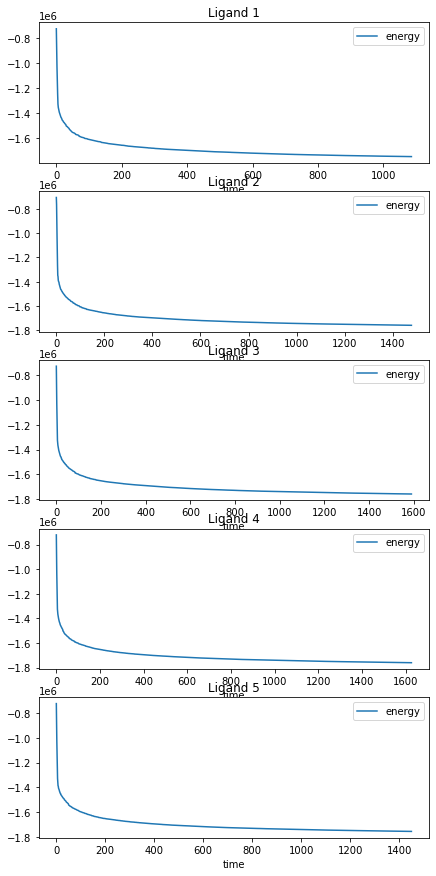

In [73]:
fig, ax = plt.subplots(5)
fig.set_size_inches(7, 15)
for i in range(1, 6):
    path = f"{structure}_pocket1/lig{i}/potential_lig{i}.xvg"
    df = pd.read_csv(path, sep='\s+', header=None, names=['time','energy'])
    df.plot("time", ax=ax[i-1])
    ax[i-1].set_title(f"Ligand {i}")

## Equilibration

### Ligand restraining

Firstly we need to create index group for ligand, which contains all non-hydrogen atoms.
```bash
gmx make_ndx -f 7NIO_pocket1/ligX/ligX.gro -o 7NIO_pocket1/ligX/index_ligX.ndx
> 0 & ! a H*
> q
```

**OUTPUT** index_ligX.ndx

Now we can run the genrestr module to restrain the ligand. We want to select the index group (3).

In [75]:
%%bash -s "$structure"
for i in {1..5}
do
    printf "3\n" | gmx genrestr -f ${1}_pocket1/lig${i}/lig${i}.gro \
    -n ${1}_pocket1/lig${i}/index_lig${i}.ndx \
    -o ${1}_pocket1/lig${i}/posre_lig${i}.itp \
    -fc 1000 1000 1000
done

                     :-) GROMACS - gmx genrestr, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx genrestr -f 7NIO_pocket1/lig1/lig1.gro -n 7NIO_pocket1/lig1/index_lig1.ndx -o 7NIO_pocket1/lig1/posre_lig1.itp -fc 1000 1000 1000


Reading structure file
Group     0 (         System) has    39 elements
Group     1 (          Other) has    39 elements
Group     2 (           LIG1) has    39 elements
Group     3 (   System_&_!H*) has    22 elements
Select a group: 
GROMACS reminds you: "Everything Must Go" (Red Hot Chili Peppers)



Select group to position restrain
Selected 3: 'System_&_!H*'


                     :-) GROMACS - gmx genrestr, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx genrestr -f 7NIO_pocket1/lig2/lig2.gro -n 7NIO_pocket1/lig2/index_lig2.ndx -o 7NIO_pocket1/lig2/posre_lig2.itp -fc 1000 1000 1000


Reading structure file
Group     0 (         System) has    37 elements
Group     1 (          Other) has    37 elements
Group     2 (           LIG2) has    37 elements
Group     3 (   System_&_!H*) has    18 elements
Select a group: 
GROMACS reminds you: "Everything Must Go" (Red Hot Chili Peppers)



Select group to position restrain
Selected 3: 'System_&_!H*'


                     :-) GROMACS - gmx genrestr, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx genrestr -f 7NIO_pocket1/lig3/lig3.gro -n 7NIO_pocket1/lig3/index_lig3.ndx -o 7NIO_pocket1/lig3/posre_lig3.itp -fc 1000 1000 1000


Reading structure file
Group     0 (         System) has    50 elements
Group     1 (          Other) has    50 elements
Group     2 (           LIG3) has    50 elements
Group     3 (   System_&_!H*) has    26 elements
Select a group: 
GROMACS reminds you: "Everything Must Go" (Red Hot Chili Peppers)



Select group to position restrain
Selected 3: 'System_&_!H*'


                     :-) GROMACS - gmx genrestr, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx genrestr -f 7NIO_pocket1/lig4/lig4.gro -n 7NIO_pocket1/lig4/index_lig4.ndx -o 7NIO_pocket1/lig4/posre_lig4.itp -fc 1000 1000 1000


Reading structure file
Group     0 (         System) has    47 elements
Group     1 (          Other) has    47 elements
Group     2 (           LIG4) has    47 elements
Group     3 (   System_&_!H*) has    23 elements
Select a group: 
GROMACS reminds you: "Everything Must Go" (Red Hot Chili Peppers)



Select group to position restrain
Selected 3: 'System_&_!H*'


                     :-) GROMACS - gmx genrestr, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx genrestr -f 7NIO_pocket1/lig5/lig5.gro -n 7NIO_pocket1/lig5/index_lig5.ndx -o 7NIO_pocket1/lig5/posre_lig5.itp -fc 1000 1000 1000


Reading structure file
Group     0 (         System) has    61 elements
Group     1 (          Other) has    61 elements
Group     2 (           LIG5) has    61 elements
Group     3 (   System_&_!H*) has    28 elements
Select a group: 
GROMACS reminds you: "Everything Must Go" (Red Hot Chili Peppers)



Select group to position restrain
Selected 3: 'System_&_!H*'


**OUTPUT** posre_ligX.itp

Now we need to include the generated restraints in the topology file. Do it manually by adding
```
; Ligand position restraints
#ifdef POSRES
#include "posre_ligX.itp"
#endif
```
after this part
```
; Include ligand topology
#include "ligX.itp"
```
**OUTPUT** update complex_ligX.top

### Grouping ligand and protein

For equilibration we need GROMACS to consider ligand + protein to be one group and solvent + ions to be another group. Therefore we create a custom index file for protein + ligand.
```bash
gmx make_ndx -f 7NIO_pocket1/ligX/energ_min_ligX.gro -o 7NIO_pocket1/ligX/index_complex_ligX.ndx
> 1 | 13 # Protein or LIGX
> q
```
**OUTPUT** index_complex_ligX.ndx

### NVT equilibration

Generate binary .tpr files for the run.<br> 
nvt.mdp file was adjusted to include:
```
tc-grps                 = Protein_LIGX Water_and_ions
```

In [77]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx grompp -f ${1}_pocket1/lig${i}/nvt_lig${i}.mdp \
        -c ${1}_pocket1/lig${i}/energ_min_lig${i}.gro \
        -r ${1}_pocket1/lig${i}/energ_min_lig${i}.gro \
        -p ${1}_pocket1/lig${i}/complex_lig${i}.top \
        -n ${1}_pocket1/lig${i}/index_complex_lig${i}.ndx \
        -o ${1}_pocket1/lig${i}/nvt_lig${i}.tpr
done

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig1/nvt_lig1.mdp -c 7NIO_pocket1/lig1/energ_min_lig1.gro -r 7NIO_pocket1/lig1/energ_min_lig1.gro -p 7NIO_pocket1/lig1/complex_lig1.top -n 7NIO_pocket1/lig1/index_complex_lig1.ndx -o 7NIO_pocket1/lig1/nvt_lig1.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG1 is 23244.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208194.30

NOTE 1 [file 7NIO_pocket1/lig1/nvt_lig1.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There was 1 note

GROMACS reminds 

Setting the LD random seed to -1077972993

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG1'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -755499014

Velocities were taken from a Maxwell distribution at 300 K

The largest distance between excluded atoms is 0.421 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.221 nm, buffer size 0.021 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier gri

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig2/nvt_lig2.mdp -c 7NIO_pocket1/lig2/energ_min_lig2.gro -r 7NIO_pocket1/lig2/energ_min_lig2.gro -p 7NIO_pocket1/lig2/complex_lig2.top -n 7NIO_pocket1/lig2/index_complex_lig2.ndx -o 7NIO_pocket1/lig2/nvt_lig2.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG2 is 23236.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208224.30

NOTE 1 [file 7NIO_pocket1/lig2/nvt_lig2.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There was 1 note

GROMACS reminds 

Setting the LD random seed to -1107428054

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG2'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to 2146302461

Velocities were taken from a Maxwell distribution at 300 K

The largest distance between excluded atoms is 0.423 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.221 nm, buffer size 0.021 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier gri

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig3/nvt_lig3.mdp -c 7NIO_pocket1/lig3/energ_min_lig3.gro -r 7NIO_pocket1/lig3/energ_min_lig3.gro -p 7NIO_pocket1/lig3/complex_lig3.top -n 7NIO_pocket1/lig3/index_complex_lig3.ndx -o 7NIO_pocket1/lig3/nvt_lig3.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG3 is 23267.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208176.30

NOTE 1 [file 7NIO_pocket1/lig3/nvt_lig3.mdp]:
  There are 1 non-linear virtual site constructions. Their contribution to
  the energy error is approximated. In most cases this does not affect the
  error significantly.


NOTE 2 [file 7NIO_pocket1/lig3/nvt_lig3.mdp]:
  Removing center of mas

Setting the LD random seed to -25166849

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG3'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -620789770

Velocities were taken from a Maxwell distribution at 300 K

Cleaning up constraints and constant bonded interactions with virtual sites

The largest distance between excluded atoms is 0.562 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.221 nm, buffer size 0.021 nm

Note that mdrun will re

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig4/nvt_lig4.mdp -c 7NIO_pocket1/lig4/energ_min_lig4.gro -r 7NIO_pocket1/lig4/energ_min_lig4.gro -p 7NIO_pocket1/lig4/complex_lig4.top -n 7NIO_pocket1/lig4/index_complex_lig4.ndx -o 7NIO_pocket1/lig4/nvt_lig4.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG4 is 23261.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208200.30

NOTE 1 [file 7NIO_pocket1/lig4/nvt_lig4.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There was 1 note

GROMACS reminds 

Setting the LD random seed to -1008732226

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG4'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -46143877

Velocities were taken from a Maxwell distribution at 300 K

The largest distance between excluded atoms is 0.424 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.221 nm, buffer size 0.021 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig5/nvt_lig5.mdp -c 7NIO_pocket1/lig5/energ_min_lig5.gro -r 7NIO_pocket1/lig5/energ_min_lig5.gro -p 7NIO_pocket1/lig5/complex_lig5.top -n 7NIO_pocket1/lig5/index_complex_lig5.ndx -o 7NIO_pocket1/lig5/nvt_lig5.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG5 is 23294.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208176.30

NOTE 1 [file 7NIO_pocket1/lig5/nvt_lig5.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.


There was 1 note

GROMACS reminds 

Setting the LD random seed to -151012993

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG5'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -289672101

Velocities were taken from a Maxwell distribution at 300 K

The largest distance between excluded atoms is 0.424 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.221 nm, buffer size 0.021 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid

**OUTPUT** nvt_ligX.tpr

Now we can start the equilibration NVT run

In [78]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx mdrun -deffnm ${1}_pocket1/lig${i}/nvt_lig${i}  \
        -s ${1}_pocket1/lig${i}/nvt_lig${i}.tpr
done

                      :-) GROMACS - gmx mdrun, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx mdrun -deffnm 7NIO_pocket1/lig1/nvt_lig1 -s 7NIO_pocket1/lig1/nvt_lig1.tpr

Reading file 7NIO_pocket1/lig1/nvt_lig1.tpr, VERSION 2022.4 (single precision)
Changing nstlist from 20 to 100, rlist from 1.221 to 1.341

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 12 OpenMP threads 

starting mdrun 'Protein in water'
50000 steps,    100.0 ps.

Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:     1889.946      157.496     1200.0
                 (ns/day)    (hour/ns)
Performance:       54.860      

**OUTPUT** nvt_ligX.gro, nvt_ligX.log, nvt_ligX.edr, nvt_ligX.cpt, nvt_ligX.xtc 

**Analysis**<br>
Firstly, collect temperature data

In [79]:
%%bash
for i in {1..5}
do
    echo "Temperature" | gmx energy \
        -f ${1}_pocket1/lig${i}/nvt_lig${i}.edr \
        -o ${1}_pocket1/lig${i}/temperature_lig${i}.xvg \
        -xvg none
done

                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig1/nvt_lig1.edr -o 7NIO_pocket1/lig1/temperature_lig1.xvg -xvg none

Opened 7NIO_pocket1/lig1/nvt_lig1.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Vir-XX          20  Vir-XY


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 299.853       0.21    3.16464     1.3525  (K)


                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig2/nvt_lig2.edr -o 7NIO_pocket1/lig2/temperature_lig2.xvg -xvg none

Opened 7NIO_pocket1/lig2/nvt_lig2.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Vir-XX          20  Vir-XY


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 299.853       0.24    3.35874    1.38216  (K)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                  299.79       0.21     3.3578    1.15845  (K)


                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig3/nvt_lig3.edr -o 7NIO_pocket1/lig3/temperature_lig3.xvg -xvg none

Opened 7NIO_pocket1/lig3/nvt_lig3.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Vir-XX          20  Vir-XY


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 299.824       0.25    3.37854    1.44184  (K)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 299.754       0.21    3.28482     1.4306  (K)


**OUTPUT** temperature_ligX.xvg<br>
Plot the data.

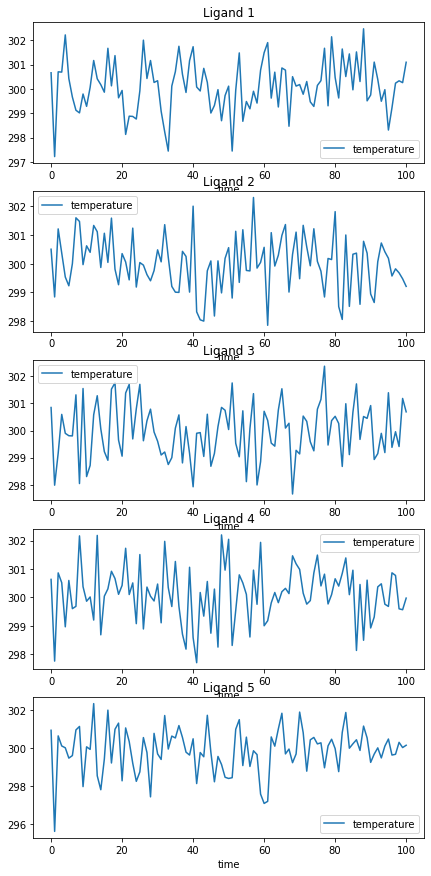

In [82]:
fig, ax = plt.subplots(5)
fig.set_size_inches(7, 15)
for i in range(1, 6):
    path = f"{structure}_pocket1/lig{i}/temperature_lig{i}.xvg"
    df = pd.read_csv(path, sep='\s+', header=None, names=['time','temperature'])
    df.plot("time", ax=ax[i-1])
    ax[i-1].set_title(f"Ligand {i}")

### NPT equilibration

Generate binary .tpr files for the run.<br> 
npt.mdp file was adjusted in following lines:
```
tc-grps                 = Protein_LIGX Water_and_ions
...
pcoupl                  = C-rescale ;instead of Berendsen 
```

In [85]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx grompp -f ${1}_pocket1/lig${i}/npt_lig${i}.mdp \
        -c ${1}_pocket1/lig${i}/nvt_lig${i}.gro \
        -t ${1}_pocket1/lig${i}/nvt_lig${i}.cpt \
        -r ${1}_pocket1/lig${i}/nvt_lig${i}.gro \
        -p ${1}_pocket1/lig${i}/complex_lig${i}.top \
        -n ${1}_pocket1/lig${i}/index_complex_lig${i}.ndx \
        -o ${1}_pocket1/lig${i}/npt_lig${i}.tpr
done

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig1/npt_lig1.mdp -c 7NIO_pocket1/lig1/nvt_lig1.gro -t 7NIO_pocket1/lig1/nvt_lig1.cpt -r 7NIO_pocket1/lig1/nvt_lig1.gro -p 7NIO_pocket1/lig1/complex_lig1.top -n 7NIO_pocket1/lig1/index_complex_lig1.ndx -o 7NIO_pocket1/lig1/npt_lig1.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG1 is 23244.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208194.30

NOTE 1 [file 7NIO_pocket1/lig1/npt_lig1.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Last frame   

Setting the LD random seed to -1478496353

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG1'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The center of mass of the position restraint coord's is  8.812  8.788  4.150

The center of mass of the position restraint coord's is  8.812  8.788  4.150

The largest distance between excluded atoms is 0.438 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.221 nm, buffer size 0.021 nm

Note that mdrun will redetermine r

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig2/npt_lig2.mdp -c 7NIO_pocket1/lig2/nvt_lig2.gro -t 7NIO_pocket1/lig2/nvt_lig2.cpt -r 7NIO_pocket1/lig2/nvt_lig2.gro -p 7NIO_pocket1/lig2/complex_lig2.top -n 7NIO_pocket1/lig2/index_complex_lig2.ndx -o 7NIO_pocket1/lig2/npt_lig2.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG2 is 23236.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208224.30

NOTE 1 [file 7NIO_pocket1/lig2/npt_lig2.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Last frame   

Setting the LD random seed to -1099171842

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG2'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The center of mass of the position restraint coord's is  8.811  8.789  4.148

The center of mass of the position restraint coord's is  8.811  8.789  4.148

The largest distance between excluded atoms is 0.430 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.221 nm, buffer size 0.021 nm

Note that mdrun will redetermine r

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig3/npt_lig3.mdp -c 7NIO_pocket1/lig3/nvt_lig3.gro -t 7NIO_pocket1/lig3/nvt_lig3.cpt -r 7NIO_pocket1/lig3/nvt_lig3.gro -p 7NIO_pocket1/lig3/complex_lig3.top -n 7NIO_pocket1/lig3/index_complex_lig3.ndx -o 7NIO_pocket1/lig3/npt_lig3.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG3 is 23267.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208176.30

NOTE 1 [file 7NIO_pocket1/lig3/npt_lig3.mdp]:
  There are 1 non-linear virtual site constructions. Their contribution to
  the energy error is approximated. In most cases this does not affect the
  error significantly.


NOTE 2 [file 7NIO_pocket1/lig3/npt_lig3.mdp]:
  

Setting the LD random seed to 1071341497

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG3'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Cleaning up constraints and constant bonded interactions with virtual sites

The center of mass of the position restraint coord's is  8.813  8.789  4.148

The center of mass of the position restraint coord's is  8.813  8.789  4.148

The largest distance between excluded atoms is 0.566 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig4/npt_lig4.mdp -c 7NIO_pocket1/lig4/nvt_lig4.gro -t 7NIO_pocket1/lig4/nvt_lig4.cpt -r 7NIO_pocket1/lig4/nvt_lig4.gro -p 7NIO_pocket1/lig4/complex_lig4.top -n 7NIO_pocket1/lig4/index_complex_lig4.ndx -o 7NIO_pocket1/lig4/npt_lig4.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG4 is 23261.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208200.30

NOTE 1 [file 7NIO_pocket1/lig4/npt_lig4.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Last frame   

Setting the LD random seed to 2063177977

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG4'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The center of mass of the position restraint coord's is  8.812  8.788  4.149

The center of mass of the position restraint coord's is  8.812  8.788  4.149

The largest distance between excluded atoms is 0.425 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.221 nm, buffer size 0.021 nm

Note that mdrun will redetermine rl

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig5/npt_lig5.mdp -c 7NIO_pocket1/lig5/nvt_lig5.gro -t 7NIO_pocket1/lig5/nvt_lig5.cpt -r 7NIO_pocket1/lig5/nvt_lig5.gro -p 7NIO_pocket1/lig5/complex_lig5.top -n 7NIO_pocket1/lig5/index_complex_lig5.ndx -o 7NIO_pocket1/lig5/npt_lig5.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG5 is 23294.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208176.30

NOTE 1 [file 7NIO_pocket1/lig5/npt_lig5.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Last frame   

Setting the LD random seed to -350355596

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG5'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The center of mass of the position restraint coord's is  8.812  8.788  4.149

The center of mass of the position restraint coord's is  8.812  8.788  4.149

The largest distance between excluded atoms is 0.446 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.221 nm, buffer size 0.021 nm

Note that mdrun will redetermine rl

**OUTPUT** npt_ligX.tpr

Now we can start the equilibration NPT run

In [86]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx mdrun -deffnm ${1}_pocket1/lig${i}/npt_lig${i}  \
        -s ${1}_pocket1/lig${i}/npt_lig${i}.tpr
done

                      :-) GROMACS - gmx mdrun, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx mdrun -deffnm 7NIO_pocket1/lig1/npt_lig1 -s 7NIO_pocket1/lig1/npt_lig1.tpr

Reading file 7NIO_pocket1/lig1/npt_lig1.tpr, VERSION 2022.4 (single precision)
Changing nstlist from 20 to 100, rlist from 1.221 to 1.341

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 12 OpenMP threads 

starting mdrun 'Protein in water'
50000 steps,    100.0 ps.

Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:     1961.772      163.481     1200.0
                 (ns/day)    (hour/ns)
Performance:       52.851      

**OUTPUT** npt_ligX.cpt, npt_ligX.edr, npt_ligX.gro, npt_ligX.npt_ligX.xtc

**Analysis** <br>
Collect data (density and pressure).

In [87]:
%%bash -s "$structure"
for i in {1..5}
do
    echo "Pressure" | gmx energy \
        -f ${1}_pocket1/lig${i}/npt_lig${i}.edr \
        -o ${1}_pocket1/lig${i}/pressure_lig${i}.xvg \
        -xvg none
        
    echo "Density" | gmx energy \
        -f ${1}_pocket1/lig${i}/npt_lig${i}.edr \
        -o ${1}_pocket1/lig${i}/density_lig${i}.xvg \
        -xvg none
done

                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig1/npt_lig1.edr -o 7NIO_pocket1/lig1/pressure_lig1.xvg -xvg none

Opened 7NIO_pocket1/lig1/npt_lig1.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Box-X           20  Box-Y    


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   -13.2358         13    105.169    90.5657  (bar)


                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig1/npt_lig1.edr -o 7NIO_pocket1/lig1/density_lig1.xvg -xvg none

Opened 7NIO_pocket1/lig1/npt_lig1.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Box-X           20  Box-Y     


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1030.99       0.95    3.51161    6.34875  (kg/m^3)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                    3.33818         12    106.824    60.2469  (bar)


                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig2/npt_lig2.edr -o 7NIO_pocket1/lig2/density_lig2.xvg -xvg none

Opened 7NIO_pocket1/lig2/npt_lig2.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Box-X           20  Box-Y     


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1031.89       0.85    3.46644    4.99795  (kg/m^3)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   -4.72493         11    106.378    49.8441  (bar)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1030.86       0.94    3.61824    4.09379  (

                      :-) GROMACS - gmx energy, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx energy -f 7NIO_pocket1/lig4/npt_lig4.edr -o 7NIO_pocket1/lig4/density_lig4.xvg -xvg none

Opened 7NIO_pocket1/lig4/npt_lig4.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Box-X           20  Box-Y     


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1031.27       0.85     3.4575    5.29296  (kg/m^3)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   -17.0837         15    101.894    76.7914  (bar)

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Density                     1030.57       0.74    3.35652     3.9866  (

**OUTPUT** pressure_ligX.xvg, density_ligX.xvg

Plot pressure.

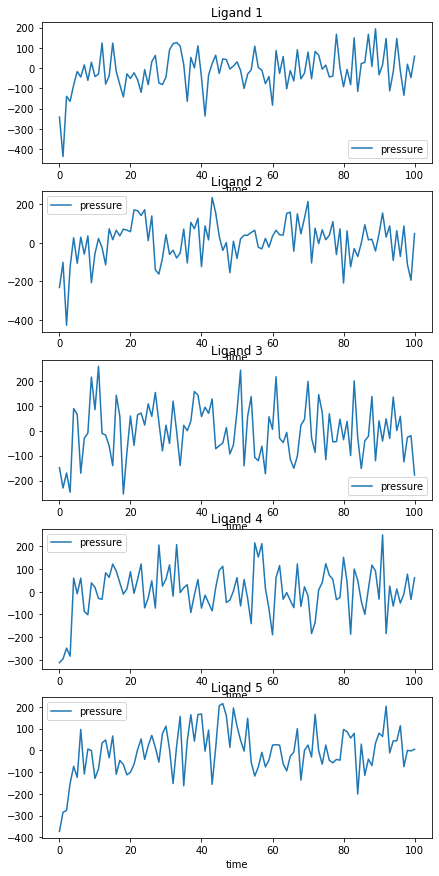

In [88]:
fig, ax = plt.subplots(5)
fig.set_size_inches(7, 15)
for i in range(1, 6):
    path = f"{structure}_pocket1/lig{i}/pressure_lig{i}.xvg"
    df = pd.read_csv(path, sep='\s+', header=None, names=['time','pressure'])
    df.plot("time", ax=ax[i-1])
    ax[i-1].set_title(f"Ligand {i}")

Plot density.

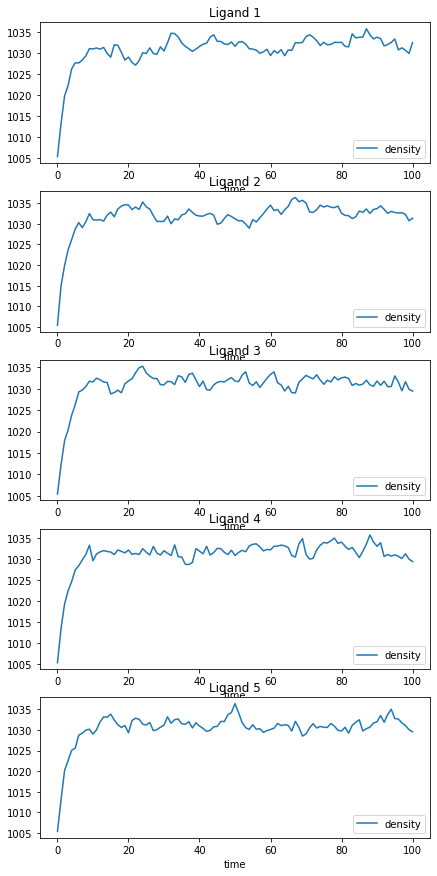

In [89]:
fig, ax = plt.subplots(5)
fig.set_size_inches(7, 15)
for i in range(1, 6):
    path = f"{structure}_pocket1/lig{i}/density_lig{i}.xvg"
    df = pd.read_csv(path, sep='\s+', header=None, names=['time','density'])
    df.plot("time", ax=ax[i-1])
    ax[i-1].set_title(f"Ligand {i}")

## Production MD Simulation

Finally, yay! :D

To test how long will the simulation approximately take, run a 100ps simulation.

In [91]:
%%bash -s "$structure"

gmx grompp -f md_test.mdp \
    -c ${1}_pocket1/lig1/npt_lig1.gro \
    -t ${1}_pocket1/lig1/npt_lig1.cpt \
    -p ${1}_pocket1/lig1/complex_lig1.top \
    -n ${1}_pocket1/lig1/index_complex_lig1.ndx \
    -o md_test.tpr

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f md_test.mdp -c 7NIO_pocket1/lig1/npt_lig1.gro -t 7NIO_pocket1/lig1/npt_lig1.cpt -p 7NIO_pocket1/lig1/complex_lig1.top -n 7NIO_pocket1/lig1/index_complex_lig1.ndx -o md_test.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG1 is 23244.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208194.30
Last frame         -1 time  100.000   

GROMACS reminds you: "How wonderful that we have met with a paradox. Now we have some hope of making progress." (Niels Bohr)



Setting the LD random seed to -1372070131

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG1'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The largest distance between excluded atoms is 0.437 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.222 nm, buffer size 0.022 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

Reading Coordinates, Velocities and Box size from old trajectory

Will read whole trajectory

Using frame at t = 1

In [92]:
!gmx mdrun -deffnm md_test -v

                      :-) GROMACS - gmx mdrun, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx mdrun -deffnm md_test -v

Reading file md_test.tpr, VERSION 2022.4 (single precision)
Changing nstlist from 20 to 100, rlist from 1.222 to 1.342

1 GPU selected for this run.
Mapping of GPU IDs to the 2 GPU tasks in the 1 rank on this node:
  PP:0,PME:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
PME tasks will do all aspects on the GPU
Using 1 MPI thread
Using 12 OpenMP threads 

starting mdrun 'Protein in water'
50000 steps,    100.0 ps.
step 1700: timed with pme grid 80 80 80, coulomb cutoff 1.200: 828.9 M-cycles
step 1900: timed with pme grid 64 64 64, coulomb cutoff 1.363: 1013.0 M-cycles
step 2100: timed with pme grid 72 72 72, coulomb cutoff 1.212: 853.4 M-cycles
step 2300: timed with pme grid 80

Generate binary files for the MD simulation.

In [93]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx grompp -f ${1}_pocket1/lig${i}/md_10ns_lig${i}.mdp \
        -c ${1}_pocket1/lig${i}/npt_lig${i}.gro \
        -t ${1}_pocket1/lig${i}/npt_lig${i}.cpt \
        -p ${1}_pocket1/lig${i}/complex_lig${i}.top \
        -n ${1}_pocket1/lig${i}/index_complex_lig${i}.ndx \
        -o ${1}_pocket1/lig${i}/md_10ns_lig${i}.tpr
done

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig1/md_10ns_lig1.mdp -c 7NIO_pocket1/lig1/npt_lig1.gro -t 7NIO_pocket1/lig1/npt_lig1.cpt -p 7NIO_pocket1/lig1/complex_lig1.top -n 7NIO_pocket1/lig1/index_complex_lig1.ndx -o 7NIO_pocket1/lig1/md_10ns_lig1.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG1 is 23244.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208194.30
Last frame         -1 time  100.000   

GROMACS reminds you: "Unlike teachers or doctors, our efforts improve the lives of people we'll never meet." (Katie Busch-Sorensen)



Setting the LD random seed to -140002836

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG1'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The largest distance between excluded atoms is 0.437 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.222 nm, buffer size 0.022 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

Reading Coordinates, Velocities and Box size from old trajectory

Will read whole trajectory

Using frame at t = 10

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig2/md_10ns_lig2.mdp -c 7NIO_pocket1/lig2/npt_lig2.gro -t 7NIO_pocket1/lig2/npt_lig2.cpt -p 7NIO_pocket1/lig2/complex_lig2.top -n 7NIO_pocket1/lig2/index_complex_lig2.ndx -o 7NIO_pocket1/lig2/md_10ns_lig2.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG2 is 23236.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208224.30
Last frame         -1 time  100.000   

GROMACS reminds you: "The Path Of the Righteous Man is Beset On All Sides With the Iniquities Of the Selfish and the Tyranny Of Evil Men." (Pulp Fiction)



Setting the LD random seed to -277974025

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG2'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The largest distance between excluded atoms is 0.436 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.222 nm, buffer size 0.022 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

Reading Coordinates, Velocities and Box size from old trajectory

Will read whole trajectory

Using frame at t = 10

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig3/md_10ns_lig3.mdp -c 7NIO_pocket1/lig3/npt_lig3.gro -t 7NIO_pocket1/lig3/npt_lig3.cpt -p 7NIO_pocket1/lig3/complex_lig3.top -n 7NIO_pocket1/lig3/index_complex_lig3.ndx -o 7NIO_pocket1/lig3/md_10ns_lig3.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG3 is 23267.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208176.30

NOTE 1 [file 7NIO_pocket1/lig3/md_10ns_lig3.mdp]:
  There are 1 non-linear virtual site constructions. Their contribution to
  the energy error is approximated. In most cases this does not affect the
  error significantly.

Last frame         -1 time  100.000   

There was 1 note

GROMACS remin

Setting the LD random seed to 805034958

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG3'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Cleaning up constraints and constant bonded interactions with virtual sites

The largest distance between excluded atoms is 0.568 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.222 nm, buffer size 0.022 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

Reading Coordinates, Velocities and Box

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig4/md_10ns_lig4.mdp -c 7NIO_pocket1/lig4/npt_lig4.gro -t 7NIO_pocket1/lig4/npt_lig4.cpt -p 7NIO_pocket1/lig4/complex_lig4.top -n 7NIO_pocket1/lig4/index_complex_lig4.ndx -o 7NIO_pocket1/lig4/md_10ns_lig4.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG4 is 23261.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208200.30
Last frame         -1 time  100.000   

GROMACS reminds you: "Physics is like sex: sure, it may give some practical results, but that's not why we do it" (Richard P. Feynman)



Setting the LD random seed to -4718849

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG4'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The largest distance between excluded atoms is 0.431 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.222 nm, buffer size 0.022 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

Reading Coordinates, Velocities and Box size from old trajectory

Will read whole trajectory

Using frame at t = 100 

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx grompp -f 7NIO_pocket1/lig5/md_10ns_lig5.mdp -c 7NIO_pocket1/lig5/npt_lig5.gro -t 7NIO_pocket1/lig5/npt_lig5.cpt -p 7NIO_pocket1/lig5/complex_lig5.top -n 7NIO_pocket1/lig5/index_complex_lig5.ndx -o 7NIO_pocket1/lig5/md_10ns_lig5.tpr

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'
Generating 1-4 interactions: fudge = 1
Number of degrees of freedom in T-Coupling group Protein_LIG5 is 23294.70
Number of degrees of freedom in T-Coupling group Water_and_ions is 208176.30
Last frame         -1 time  100.000   

GROMACS reminds you: "We ignore public understanding of science at our peril." (Eugenie Clark)



Setting the LD random seed to -1946357779

Generated 167799 of the 167910 non-bonded parameter combinations

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'LIG5'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

The largest distance between excluded atoms is 0.425 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.294 nm, buffer size 0.094 nm

Set rlist, assuming 4x4 atom pair-list, to 1.222 nm, buffer size 0.022 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

Reading Coordinates, Velocities and Box size from old trajectory

Will read whole trajectory

Using frame at t = 1

**OUTPUT** md_10ns_ligX.tpr

Run the 10 ns with the following .sh script in tmux.<br>

md_10ns_run.sh
```bash
#!/bin/bash
for i in {1..5}
do
    gmx mdrun -deffnm 7NIO_pocket1/lig${i}/md_10ns_lig${i}  \
        -s 7NIO_pocket1/lig${i}/md_10ns_lig${i}.tpr -v
done
```

In the terminal:

```bash
chmod +x md_10ns_run.sh
./md_10ns_run.sh > md_10ns_output.txt
```
For me for some reason it still didn't write the output in the output file, but it doesn't matter.

**OUTPUT** md_10ns_ligX.cpt, md_10ns_ligX.edr, md_10ns_ligX.gro, md_10ns_ligX.log, md_10ns_ligX.xct

## Postprocessing

First recenter the system. For this run in terminal the following command.
```
gmx trjconv -s 7NIO_pocket1/ligX/md_10ns_ligX.tpr -f 7NIO_pocket1/ligX/md_10ns_ligX.xtc -o 7NIO_pocket1/ligX/md_10ns_ligX_center.xtc -center -pbc mol -ur compact
> Group for centering? 1(Protein)
> Group for output? 0(System)
```


**OUTPUT** md_10ns_ligX_center.xtc

Now we want also to perform rotational and translational fitting of the coordinates (only for visualization, not for later calculations)
```
gmx trjconv -s 7NIO_pocket1/ligX/md_10ns_ligX.tpr -f 7NIO_pocket1/ligX/md_10ns_ligX_center.xtc -o 7NIO_pocket1/ligX/md_10ns_ligX_fitted.xtc -fit rot+trans
> Select group for least squares fit: 4(Backbone)
> Group for output? 0(System)
```

**OUTPUT** md_10ns_ligX_fitted.xtc

## Analysis

### Distance

Firstly we want to look how the distance between the center of mass of the ligand and center of mass of the protein changes over time

In [9]:
%%bash -s "$structure"
for i in {1..5}
do
    gmx distance -f ${1}_pocket1/lig${i}/md_10ns_lig${i}_center.xtc \
        -s ${1}_pocket1/lig${i}/npt_lig${i}.gro \
        -oall ${1}_pocket1/lig${i}/distance_com_lig${i}.xvg \
        -select "com of group Backbone plus com of group LIG$i"
done

                     :-) GROMACS - gmx distance, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx distance -f 7NIO_pocket1/lig3/md_10ns_lig3_center.xtc -s 7NIO_pocket1/lig3/npt_lig3.gro -oall 7NIO_pocket1/lig3/distance_com_lig3.xvg -select 'com of group Backbone plus com of (group LIG3 and not name LP)'

Can not find mass in database for atom LP1 in residue 595 LIG3

-------------------------------------------------------
Program:     gmx distance, version 2022.4
Source file: src/gromacs/selection/selectionoptionbehavior.cpp (line 164)
Function:    void gmx::SelectionOptionBehavior::Impl::getMassesIfRequired(gmx_mtop_t*) const

Inconsistency in user input:
Selections require mass information for evaluation, but it is not available in
the input and could not be determined for all atoms based on atom names.

For more information and tips for troubleshooting, please check the GROMA


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.



CalledProcessError: Command 'b'for i in {3..3}\ndo\n    gmx distance -f 7NIO_pocket1/lig${i}/md_10ns_lig${i}_center.xtc \\\n        -s 7NIO_pocket1/lig${i}/npt_lig${i}.gro \\\n        -oall 7NIO_pocket1/lig${i}/distance_com_lig${i}.xvg \\\n        -select "com of group Backbone plus com of (group LIG$i and not name LP)"\ndone\n'' returned non-zero exit status 1.

This fails for ligand 3, because it has LP atom (lone pair). => copy .gro and change LP to H25 (npt_lig3_HinsteadLP.gro)

In [28]:
%%bash -s "$structure"
i=3
gmx distance -f ${1}_pocket1/lig${i}/md_10ns_lig${i}_center.xtc \
        -s ${1}_pocket1/lig${i}/npt_lig${i}_HinsteadLP.gro \
        -oall ${1}_pocket1/lig${i}/distance_com_lig${i}.xvg \
        -select "com of group Backbone plus com of group LIG3"

                     :-) GROMACS - gmx distance, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx distance -f 7NIO_pocket1/lig3/md_10ns_lig3_center.xtc -s 7NIO_pocket1/lig3/npt_lig3_HinsteadLP.gro -oall 7NIO_pocket1/lig3/distance_com_lig3.xvg -select 'com of group Backbone plus com of group LIG3'

Last frame       1000 time 10000.000   
Analyzed 1001 frames, last time 10000.000

GROMACS reminds you: "Throwing the Baby Away With the SPC" (S. Hayward)




         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

com of group Backbone plus com of group LIG3:
  Number of samples:  1001
  Average distance:   1.14162  nm
  Standard deviation: 0.07060  nm


**OUTPUT** distance_com_ligX.xvg

Now we can plot the results

In [3]:
df = pd.DataFrame()
for i in range(1, 6):
    path = f"{structure}_pocket1/lig{i}/distance_com_lig{i}.xvg"
    new_df = pd.read_csv(path, sep='\s+', 
                     skiprows=17,
                     header=None, names=['Time',f"Ligand {i}"])
    if i==1:
        df = new_df
    else:
        df[f"Ligand {i}"] = new_df[f"Ligand {i}"]
    mean = df[f"Ligand {i}"].mean()
    std = df[f"Ligand {i}"].std()
    df = df.rename(columns={f"Ligand {i}":f"Ligand {i}: mean {mean:3.2f}, std {std:3.2f}"})
df_melt = df.melt(id_vars='Time', var_name='Sample', value_name='Distance')

In [12]:
# Time to ns
df_melt['Time'] = df_melt['Time']/1000

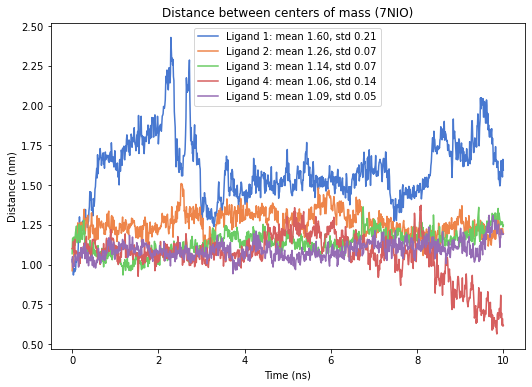

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(8.5, 6)
sns.lineplot(df_melt, 
             x='Time', 
             y='Distance', 
             hue='Sample', 
             ax=ax, 
             palette="muted")
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Distance (nm)')
ax.set_title('Distance between centers of mass (7NIO)')
ax.legend().set_title(None)
fig.savefig('Distance_over_time_7NIO.png', dpi=600)

### Ligand RMSD

This calculates RMSD for the ligand. Two possibilities:
- gmx rms: performs least-square fitting first
- gmx rmsdist: fit-free method

Since we are interested in how much the ligand moves relatively to the protein, gmw rmsdist is the better option

In [99]:
%%bash - "$structure"
for i in {1..5}
do
    echo LIG$i | gmx rmsdist -f ${1}_pocket1/lig${i}/md_10ns_lig${i}_center.xtc \
    -s ${1}_pocket1/lig${i}/npt_lig${i}.gro \
    -o ${1}_pocket1/lig${i}/rmsd_lig${i}.xvg
done

                     :-) GROMACS - gmx rmsdist, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx rmsdist -f 7NIO_pocket1/lig1/md_10ns_lig1_center.xtc -s 7NIO_pocket1/lig1/npt_lig1.gro -o 7NIO_pocket1/lig1/rmsd_lig1.xvg

Group     0 (         System) has 113387 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 elements
Group     8 (      SideChain) has  6315 elements
Group     9 (    SideChain-H) has  2260 elements
Group    10 (    Prot-Masses) has  9255 elements
Group    11 (    non-Protein) has 104132 elements
Group    12 (          Other) has    39 elements
Group    13 (           LIG1) ha

Selected 13: 'LIG1'


                     :-) GROMACS - gmx rmsdist, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx rmsdist -f 7NIO_pocket1/lig2/md_10ns_lig2_center.xtc -s 7NIO_pocket1/lig2/npt_lig2.gro -o 7NIO_pocket1/lig2/rmsd_lig2.xvg

Group     0 (         System) has 113400 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 elements
Group     8 (      SideChain) has  6315 elements
Group     9 (    SideChain-H) has  2260 elements
Group    10 (    Prot-Masses) has  9255 elements
Group    11 (    non-Protein) has 104145 elements
Group    12 (          Other) has    37 elements
Group    13 (           LIG2) ha

Selected 13: 'LIG2'


                     :-) GROMACS - gmx rmsdist, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx rmsdist -f 7NIO_pocket1/lig3/md_10ns_lig3_center.xtc -s 7NIO_pocket1/lig3/npt_lig3.gro -o 7NIO_pocket1/lig3/rmsd_lig3.xvg

Group     0 (         System) has 113389 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 elements
Group     8 (      SideChain) has  6315 elements
Group     9 (    SideChain-H) has  2260 elements
Group    10 (    Prot-Masses) has  9255 elements
Group    11 (    non-Protein) has 104134 elements
Group    12 (          Other) has    50 elements
Group    13 (           LIG3) ha

Selected 13: 'LIG3'


                     :-) GROMACS - gmx rmsdist, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx rmsdist -f 7NIO_pocket1/lig4/md_10ns_lig4_center.xtc -s 7NIO_pocket1/lig4/npt_lig4.gro -o 7NIO_pocket1/lig4/rmsd_lig4.xvg

Group     0 (         System) has 113398 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 elements
Group     8 (      SideChain) has  6315 elements
Group     9 (    SideChain-H) has  2260 elements
Group    10 (    Prot-Masses) has  9255 elements
Group    11 (    non-Protein) has 104143 elements
Group    12 (          Other) has    47 elements
Group    13 (           LIG4) ha

Selected 13: 'LIG4'


                     :-) GROMACS - gmx rmsdist, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx rmsdist -f 7NIO_pocket1/lig5/md_10ns_lig5_center.xtc -s 7NIO_pocket1/lig5/npt_lig5.gro -o 7NIO_pocket1/lig5/rmsd_lig5.xvg

Group     0 (         System) has 113400 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 elements
Group     8 (      SideChain) has  6315 elements
Group     9 (    SideChain-H) has  2260 elements
Group    10 (    Prot-Masses) has  9255 elements
Group    11 (    non-Protein) has 104145 elements
Group    12 (          Other) has    61 elements
Group    13 (           LIG5) ha

Selected 13: 'LIG5'


In [33]:
df = pd.DataFrame()
for i in range(1, 6):
    path = f"{structure}_pocket1/lig{i}/rmsd_lig{i}.xvg"
    new_df = pd.read_csv(path, sep='\s+', 
                     skiprows=18,
                     header=None, names=['Time',f"Ligand {i}"])
    if i==1:
        df = new_df
    else:
        df[f"Ligand {i}"] = new_df[f"Ligand {i}"]
    mean = df[f"Ligand {i}"].mean()
    std = df[f"Ligand {i}"].std()
    df = df.rename(columns={f"Ligand {i}":f"Ligand {i}: mean {mean:3.2f}, std {std:3.2f}"})
df_melt = df.melt(id_vars='Time', var_name='Sample', value_name='RMSD')

In [34]:
# Time to ns
df_melt['Time'] = df_melt['Time']/1000

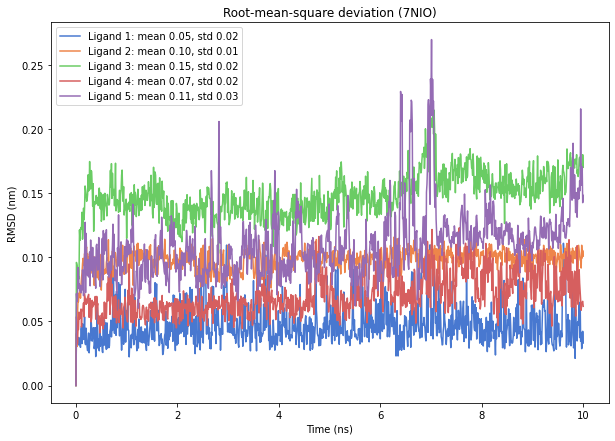

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.lineplot(df_melt, x='Time', y='RMSD', hue='Sample', ax=ax, palette='muted')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('RMSD (nm)')
ax.set_title('Root-mean-square deviation (7NIO)')
ax.legend().set_title(None)
fig.savefig('RMSD_over_time_7NIO.png', dpi=600)

### Hydrogen bonds

Hydrogen bonds can be detected with gmx hbond<br>
Good tutorial: https://www.compchems.com/how-to-study-hydrogen-bonds-using-gromacs/<br>
Also see: https://gromacswrapper.readthedocs.io/en/latest/gromacs/core/fileformats/xpm.html

```
gmx hbond -f 7NIO_pocket1/ligX/md_10ns_ligX_center.xtc \
    -s 7NIO_pocket1/ligX/md_10ns_ligX.tpr  \
    -hbn 7NIO_pocket1/ligX/index_hbonds_ligX.ndx \
    -hbm 7NIO_pocket1/ligX/matrix_hbond_ligX.xpm \
    -num 7NIO_pocket1/ligX/hbnum_ligX.xvg
> Group 1? 1 (Protein)
> Group 2? 13 (LIGX)
```

In [102]:
for i in range(1, 6):
    print(f"gmx hbond -f 7NIO_pocket1/lig{i}/md_10ns_lig{i}_center.xtc -s 7NIO_pocket1/lig{i}/md_10ns_lig{i}.tpr  -hbn 7NIO_pocket1/lig{i}/index_hbonds_lig{i}.ndx -hbm 7NIO_pocket1/lig{i}/matrix_hbond_lig{i}.xpms -num 7NIO_pocket1/lig{i}/hbnum_lig{i}.xvg")

gmx hbond -f 7NIO_pocket1/lig1/md_10ns_lig1_center.xtc -s 7NIO_pocket1/lig1/md_10ns_lig1.tpr  -hbn 7NIO_pocket1/lig1/index_hbonds_lig1.ndx -hbm 7NIO_pocket1/lig1/matrix_hbond_lig1.xpms -num 7NIO_pocket1/lig1/hbnum_lig1.xvg
gmx hbond -f 7NIO_pocket1/lig2/md_10ns_lig2_center.xtc -s 7NIO_pocket1/lig2/md_10ns_lig2.tpr  -hbn 7NIO_pocket1/lig2/index_hbonds_lig2.ndx -hbm 7NIO_pocket1/lig2/matrix_hbond_lig2.xpms -num 7NIO_pocket1/lig2/hbnum_lig2.xvg
gmx hbond -f 7NIO_pocket1/lig3/md_10ns_lig3_center.xtc -s 7NIO_pocket1/lig3/md_10ns_lig3.tpr  -hbn 7NIO_pocket1/lig3/index_hbonds_lig3.ndx -hbm 7NIO_pocket1/lig3/matrix_hbond_lig3.xpms -num 7NIO_pocket1/lig3/hbnum_lig3.xvg
gmx hbond -f 7NIO_pocket1/lig4/md_10ns_lig4_center.xtc -s 7NIO_pocket1/lig4/md_10ns_lig4.tpr  -hbn 7NIO_pocket1/lig4/index_hbonds_lig4.ndx -hbm 7NIO_pocket1/lig4/matrix_hbond_lig4.xpms -num 7NIO_pocket1/lig4/hbnum_lig4.xvg
gmx hbond -f 7NIO_pocket1/lig5/md_10ns_lig5_center.xtc -s 7NIO_pocket1/lig5/md_10ns_lig5.tpr  -hbn 7NIO_pock

With gromacswrapper we can transform XPM matrices to bool numpy arrays.

In [38]:
hb_list = []
for i in range(1, 6):
#     hb_xpm = gromacs.fileformats.xpm.XPM(
#         f"7NIO_pocket1/lig{i}/matrix_hbond_lig{i}.xpm",
#         reverse=False)
    hb_xpm = gromacs.fileformats.xpm.XPM(
        f"7NIO_pocket1/lig{i}/matrix_hbond_lig{i}.xpm")
    hb_list.append(hb_xpm.array)

Now we can calculate fraction of the time in which detected H-bonds existed.

In [39]:
hb_frac_list= []
for hb_arr in hb_list:
    hb_frac_list.append(hb_arr.mean(axis=0))

<AxesSubplot: >

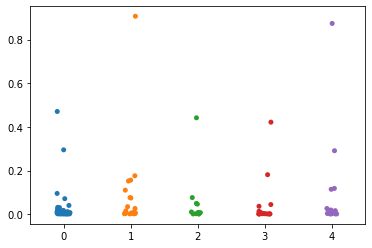

In [40]:
sns.stripplot(hb_frac_list)

20% seems a sensible cutoff to consider H-bonds

In [41]:
for i in range(1, 6):
    print('Ligand: ', i)
    print(np.where(hb_frac_list[i-1]>=0.2))

Ligand:  1
(array([17, 44]),)
Ligand:  2
(array([0]),)
Ligand:  3
(array([7]),)
Ligand:  4
(array([6]),)
Ligand:  5
(array([3, 6]),)


Now we want to load the indices for H-bonds for each ligand

In [42]:
# Read index files 
ndx_list = []
for i in range(1, 6):
    ndx_all = gromacs.fileformats.ndx.NDX(
        f"{structure}_pocket1/lig{i}/index_hbonds_lig{i}.ndx")
    ndx = ndx_all[f"hbonds_Protein-LIG{i}"]
    ndx = np.reshape(ndx, (-1, 3))
    ndx_list.append(ndx)

Now print the indexes that correspond to detected H-bonds

In [43]:
for i in range(1, 6):
    print('Ligand: ', i)
    x = ndx_list[i-1][np.where(hb_frac_list[i-1]>=0.2)]
    print(x)

Ligand:  1
[[6453   -1 9266]
 [9263   -1 6438]]
Ligand:  2
[[6320   -1 9263]]
Ligand:  3
[[9263   -1 2755]]
Ligand:  4
[[6320   -1 9265]]
Ligand:  5
[[6320   -1 9273]
 [6453   -1 9283]]


By comparing the indices with npt_ligX.gro file we can find the names of the atoms<br>
1. Ligand 1:
    1. 418LEU N - LIG1 O3
    2. LIG1 N3 - 416GLY O
2. Ligand 2:
    1. 410ARG N - LIG2 N2
3. Ligand 3:
    1. LIG3 N3 - 181TYR OH
4. Ligand 4:
    1. 410ARG N - LIG4 O1
5. Ligand 5:
    1. 410ARG N - LIG5 O2
    2. 418LEU N - LIG5 O3

We also want to plot when the bond existed over time

In [46]:
hb_plot_df = pd.DataFrame({'Time': np.arange(0, hb_list[0].shape[0])})
for i in range(5):
    hb_mat = hb_list[i]
    x=1
    for j in range(hb_mat.shape[1]):
        if np.mean(hb_mat[:, j]) >= 0.2:
            hb_plot_df[f"LIG{i+1} H-Bond #{x}"] = hb_mat[:, j]
            x += 1

In [47]:
plot_df_melt = hb_plot_df.melt(id_vars='Time', 
                               var_name = 'H_bond', 
                               value_name='exists')

In [48]:
plot_df_melt['Time'] = plot_df_melt['Time']/100

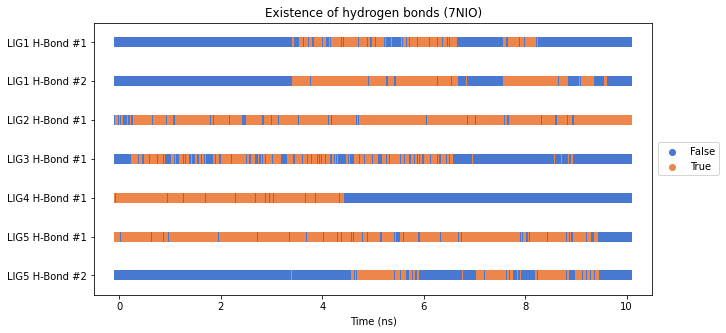

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.stripplot(plot_df_melt,
             x='Time',
             y='H_bond',
             hue='exists',
             size=10,
             marker = 's',
             jitter=False,
             ax=ax,
             palette='muted')
ax.set_ylabel(None)
ax.set_title('Existence of hydrogen bonds (7NIO)')
ax.legend(bbox_to_anchor=(1.12, 0.5), loc='center right', borderaxespad=0)
ax.set_xlabel('Time (ns)')
fig.savefig('Hbonds_over_time.png', dpi=600)

In [22]:
hb_plot_df.iloc[510, :]

Time             510
LIG1_Hbond1     True
LIG1_Hbond2     True
LIG2_Hbond1     True
LIG3_Hbond1     True
LIG4_Hbond1    False
LIG5_Hbond1     True
LIG5_Hbond2     True
Name: 510, dtype: object

To visualize the H-bonds, export frames where the bond exists

In [17]:
%%bash -s "$structure"
i=1
# For ligand 1 it is 400 step => 4000 ps
echo 20 | gmx trjconv -f ${1}_pocket1/lig${i}/md_10ns_lig${i}_center.xtc \
    -s ${1}_pocket1/lig${i}/md_10ns_lig${i}.tpr \
    -dump 4000 \
    -n ${1}_pocket1/lig${i}/index_complex_lig${i}.ndx \
    -o ${1}_pocket1/lig${i}/hb_4000ps_lig${i}.gro

                     :-) GROMACS - gmx trjconv, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx trjconv -f 7NIO_pocket1/lig1/md_10ns_lig1_center.xtc -s 7NIO_pocket1/lig1/md_10ns_lig1.tpr -dump 4000 -n 7NIO_pocket1/lig1/index_complex_lig1.ndx -o 7NIO_pocket1/lig1/hb_4000ps_lig1.gro

Will write gro: Coordinate file in Gromos-87 format
Reading file 7NIO_pocket1/lig1/md_10ns_lig1.tpr, VERSION 2022.4 (single precision)
Reading file 7NIO_pocket1/lig1/md_10ns_lig1.tpr, VERSION 2022.4 (single precision)
Group     0 (         System) has 113387 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 eleme

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 20: 'Protein_LIG1'


In [18]:
%%bash -s "$structure"
i=2
# For ligand 2 it is 400 step => 4000 ps
echo 20 | gmx trjconv -f ${1}_pocket1/lig${i}/md_10ns_lig${i}_center.xtc \
    -s ${1}_pocket1/lig${i}/md_10ns_lig${i}.tpr \
    -dump 4000 \
    -n ${1}_pocket1/lig${i}/index_complex_lig${i}.ndx \
    -o ${1}_pocket1/lig${i}/hb_4000ps_lig${i}.gro

                     :-) GROMACS - gmx trjconv, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx trjconv -f 7NIO_pocket1/lig2/md_10ns_lig2_center.xtc -s 7NIO_pocket1/lig2/md_10ns_lig2.tpr -dump 4000 -n 7NIO_pocket1/lig2/index_complex_lig2.ndx -o 7NIO_pocket1/lig2/hb_4000ps_lig2.gro

Will write gro: Coordinate file in Gromos-87 format
Reading file 7NIO_pocket1/lig2/md_10ns_lig2.tpr, VERSION 2022.4 (single precision)
Reading file 7NIO_pocket1/lig2/md_10ns_lig2.tpr, VERSION 2022.4 (single precision)
Group     0 (         System) has 113400 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 eleme

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 20: 'Protein_LIG2'


In [20]:
%%bash -s "$structure"
i=3
# For ligand 3 it is 410 step => 4100 ps
echo 20 | gmx trjconv -f ${1}_pocket1/lig${i}/md_10ns_lig${i}_center.xtc \
    -s ${1}_pocket1/lig${i}/md_10ns_lig${i}.tpr \
    -dump 4100 \
    -n ${1}_pocket1/lig${i}/index_complex_lig${i}.ndx \
    -o ${1}_pocket1/lig${i}/hb_4100ps_lig${i}.gro

                     :-) GROMACS - gmx trjconv, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx trjconv -f 7NIO_pocket1/lig3/md_10ns_lig3_center.xtc -s 7NIO_pocket1/lig3/md_10ns_lig3.tpr -dump 4100 -n 7NIO_pocket1/lig3/index_complex_lig3.ndx -o 7NIO_pocket1/lig3/hb_4000ps_lig3.gro

Will write gro: Coordinate file in Gromos-87 format
Reading file 7NIO_pocket1/lig3/md_10ns_lig3.tpr, VERSION 2022.4 (single precision)
Reading file 7NIO_pocket1/lig3/md_10ns_lig3.tpr, VERSION 2022.4 (single precision)
Group     0 (         System) has 113389 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 eleme

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 20: 'Protein_LIG3'


In [21]:
%%bash -s "$structure"
i=4
# For ligand 4 it is 410 step => 4100 ps
echo 20 | gmx trjconv -f ${1}_pocket1/lig${i}/md_10ns_lig${i}_center.xtc \
    -s ${1}_pocket1/lig${i}/md_10ns_lig${i}.tpr \
    -dump 4100 \
    -n ${1}_pocket1/lig${i}/index_complex_lig${i}.ndx \
    -o ${1}_pocket1/lig${i}/hb_4100ps_lig${i}.gro

                     :-) GROMACS - gmx trjconv, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx trjconv -f 7NIO_pocket1/lig4/md_10ns_lig4_center.xtc -s 7NIO_pocket1/lig4/md_10ns_lig4.tpr -dump 4100 -n 7NIO_pocket1/lig4/index_complex_lig4.ndx -o 7NIO_pocket1/lig4/hb_4000ps_lig4.gro

Will write gro: Coordinate file in Gromos-87 format
Reading file 7NIO_pocket1/lig4/md_10ns_lig4.tpr, VERSION 2022.4 (single precision)
Reading file 7NIO_pocket1/lig4/md_10ns_lig4.tpr, VERSION 2022.4 (single precision)
Group     0 (         System) has 113398 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 eleme

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 20: 'Protein_LIG4'


In [23]:
%%bash -s "$structure"
i=5
# For ligand 5 it is 510 step => 5100 ps
echo 20 | gmx trjconv -f ${1}_pocket1/lig${i}/md_10ns_lig${i}_center.xtc \
    -s ${1}_pocket1/lig${i}/md_10ns_lig${i}.tpr \
    -dump 5100 \
    -n ${1}_pocket1/lig${i}/index_complex_lig${i}.ndx \
    -o ${1}_pocket1/lig${i}/hb_5100ps_lig${i}.gro

                     :-) GROMACS - gmx trjconv, 2022.4 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/elizaveta/meeteu/md_simulations
Command line:
  gmx trjconv -f 7NIO_pocket1/lig5/md_10ns_lig5_center.xtc -s 7NIO_pocket1/lig5/md_10ns_lig5.tpr -dump 5100 -n 7NIO_pocket1/lig5/index_complex_lig5.ndx -o 7NIO_pocket1/lig5/hb_4000ps_lig5.gro

Will write gro: Coordinate file in Gromos-87 format
Reading file 7NIO_pocket1/lig5/md_10ns_lig5.tpr, VERSION 2022.4 (single precision)
Reading file 7NIO_pocket1/lig5/md_10ns_lig5.tpr, VERSION 2022.4 (single precision)
Group     0 (         System) has 113400 elements
Group     1 (        Protein) has  9255 elements
Group     2 (      Protein-H) has  4635 elements
Group     3 (        C-alpha) has   594 elements
Group     4 (       Backbone) has  1782 elements
Group     5 (      MainChain) has  2375 elements
Group     6 (   MainChain+Cb) has  2937 elements
Group     7 (    MainChain+H) has  2940 eleme

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 20: 'Protein_LIG5'
